In [1]:
!pip install torch


[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import torch 
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import random
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import os
import cv2
import math

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

Using: cpu


In [3]:
class neuralnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.act = torch.nn.Tanh()
        self.linear1 = torch.nn.Linear(1,6)
        self.linear2 = torch.nn.Linear(6,6)
        self.linear3 = torch.nn.Linear(6,6) 
        self.linear4 = torch.nn.Linear(6,1)
    def forward(self, X):
        X = self.linear1(X)
        X = self.act(X)
        X = self.linear2(X)
        X = self.act(X)
        X = self.linear3(X)
        X = self.act(X)
        X = self.linear4(X)
        
        return X

In [4]:
Parabola_model = neuralnet()
print(f"Architecture: {Parabola_model}")

Architecture: neuralnet(
  (act): Tanh()
  (linear1): Linear(in_features=1, out_features=6, bias=True)
  (linear2): Linear(in_features=6, out_features=6, bias=True)
  (linear3): Linear(in_features=6, out_features=6, bias=True)
  (linear4): Linear(in_features=6, out_features=1, bias=True)
)


In [5]:
X = []
Y = []
for i in range(1000):
    a = random.uniform(-2,3)
    X.append(a)
    Y.append(a**2 + 5)
X = pd.DataFrame(X, columns=['X'])
Y = pd.DataFrame(Y,columns=['Y'])
print(X.values)
print(Y.iloc[0])

[[-9.03672288e-01]
 [-1.08783410e+00]
 [ 2.66695168e+00]
 [ 1.86029673e+00]
 [-1.57975332e+00]
 [-1.19085088e+00]
 [ 2.77014222e+00]
 [ 3.46614036e-01]
 [ 2.04356243e+00]
 [-3.44917434e-01]
 [-4.99789393e-01]
 [ 5.32181922e-01]
 [ 1.32534158e+00]
 [-1.08778150e+00]
 [ 1.60011157e+00]
 [ 2.54207876e+00]
 [-7.40044006e-01]
 [ 1.00844449e+00]
 [-1.83345266e+00]
 [ 1.69304161e+00]
 [-1.22160097e+00]
 [-1.18409620e+00]
 [ 1.58993897e+00]
 [-1.18670617e+00]
 [-5.14753188e-02]
 [-1.86530092e+00]
 [ 2.47218146e+00]
 [ 2.04015505e+00]
 [ 8.35287099e-01]
 [ 7.80708912e-01]
 [ 5.17076874e-01]
 [-1.72781695e+00]
 [ 5.28191421e-01]
 [ 9.81607151e-01]
 [ 1.66484745e+00]
 [ 2.87963093e+00]
 [ 2.31888363e+00]
 [ 2.02053730e+00]
 [ 1.90403026e+00]
 [-1.84899213e+00]
 [-1.42020615e+00]
 [-1.13134811e+00]
 [-1.05658507e+00]
 [ 1.44843452e+00]
 [-9.49736336e-01]
 [ 1.59617041e+00]
 [ 2.76453929e+00]
 [ 3.54445187e-01]
 [-9.28135255e-01]
 [ 4.54352736e-01]
 [ 8.38580049e-01]
 [ 1.50986595e+00]
 [ 2.6804515

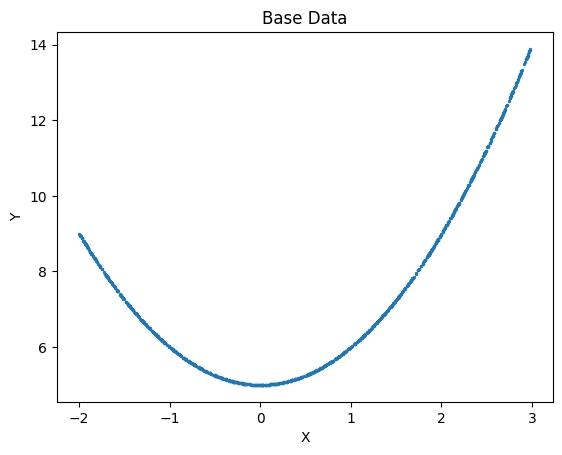

In [6]:
df = pd.concat([X,Y],axis=1)
df.head()
df.plot(kind='scatter',x='X',y='Y', s=2)
plt.title('Base Data')
# plt.show()
plt.savefig('C:/Projects/AI-learning/Py-torch proto/base_Data.png')
# img = cv2.imread('C:/Projects/AI-learning/Neural Network/From-scratch/base_Data.png')
# cv2.imshow('image',img)
# height, width, layers = img.shape
# print(df.shape)

In [7]:
class MyDataset(Dataset):
    def __init__(self, X, Y):
        super().__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [8]:
Data = MyDataset(X.values,Y.values)
# print(Data.X)
dataset = DataLoader(Data, batch_size= 1000, shuffle=True)

loss = nn.MSELoss()
opt = torch.optim.Adam(Parabola_model.parameters(), lr=0.001)



In [9]:
def train_loop(dataloader, model, loss_fn, optimizer, batch_size):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
print(X)

            X
0   -0.903672
1   -1.087834
2    2.666952
3    1.860297
4   -1.579753
..        ...
995 -1.684999
996  0.332219
997 -0.667410
998 -0.845841
999 -1.765728

[1000 rows x 1 columns]


In [12]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

# Create Dataset and DataLoader
X_numpy = numpy.stack(X.values)
X_tensor = torch.tensor(X_numpy, dtype=torch.float32)
dataset_x = CustomDataset(X_tensor)
dataloader_x = DataLoader(dataset, batch_size=1000, shuffle=True)


Epoch: 1
------------------
loss: 58.202930  [ 1000/ 1000]
Epoch: 2
------------------
loss: 58.084114  [ 1000/ 1000]
Epoch: 3
------------------
loss: 57.965553  [ 1000/ 1000]
Epoch: 4
------------------
loss: 57.847252  [ 1000/ 1000]
Epoch: 5
------------------
loss: 57.729225  [ 1000/ 1000]
Epoch: 6
------------------
loss: 57.611462  [ 1000/ 1000]
Epoch: 7
------------------
loss: 57.493977  [ 1000/ 1000]
Epoch: 8
------------------
loss: 57.376766  [ 1000/ 1000]
Epoch: 9
------------------
loss: 57.259834  [ 1000/ 1000]
Epoch: 10
------------------
loss: 57.143188  [ 1000/ 1000]
Epoch: 11
------------------
loss: 57.026821  [ 1000/ 1000]
Epoch: 12
------------------
loss: 56.910732  [ 1000/ 1000]
Epoch: 13
------------------
loss: 56.794910  [ 1000/ 1000]
Epoch: 14
------------------
loss: 56.679356  [ 1000/ 1000]
Epoch: 15
------------------
loss: 56.564056  [ 1000/ 1000]
Epoch: 16
------------------
loss: 56.449001  [ 1000/ 1000]
Epoch: 17
------------------
loss: 56.334175  [ 1

c:\Users\arpit\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


Epoch: 22
------------------
loss: 55.762878  [ 1000/ 1000]
Epoch: 23
------------------
loss: 55.649014  [ 1000/ 1000]
Epoch: 24
------------------
loss: 55.535206  [ 1000/ 1000]
Epoch: 25
------------------
loss: 55.421425  [ 1000/ 1000]
Epoch: 26
------------------
loss: 55.307640  [ 1000/ 1000]
Epoch: 27
------------------
loss: 55.193802  [ 1000/ 1000]
Epoch: 28
------------------
loss: 55.079884  [ 1000/ 1000]
Epoch: 29
------------------
loss: 54.965828  [ 1000/ 1000]
Epoch: 30
------------------
loss: 54.851601  [ 1000/ 1000]
Epoch: 31
------------------
loss: 54.737156  [ 1000/ 1000]
Epoch: 32
------------------
loss: 54.622452  [ 1000/ 1000]
Epoch: 33
------------------
loss: 54.507431  [ 1000/ 1000]
Epoch: 34
------------------
loss: 54.392056  [ 1000/ 1000]
Epoch: 35
------------------
loss: 54.276276  [ 1000/ 1000]
Epoch: 36
------------------
loss: 54.160049  [ 1000/ 1000]
Epoch: 37
------------------
loss: 54.043327  [ 1000/ 1000]
Epoch: 38
------------------
loss: 53.92

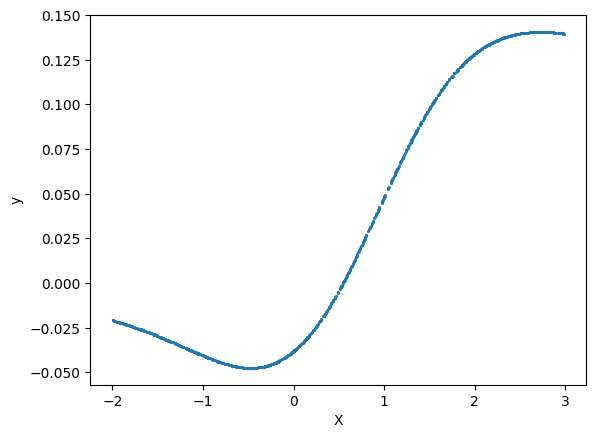

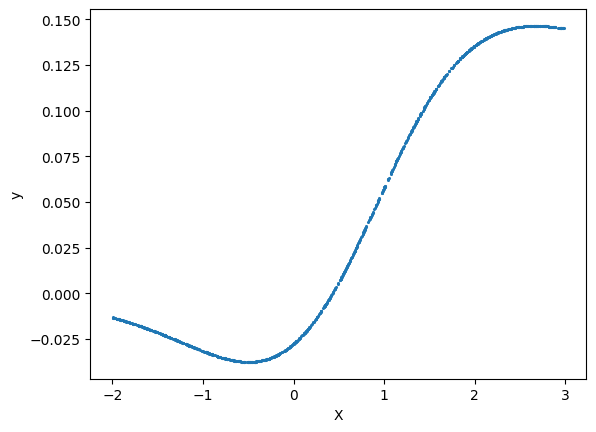

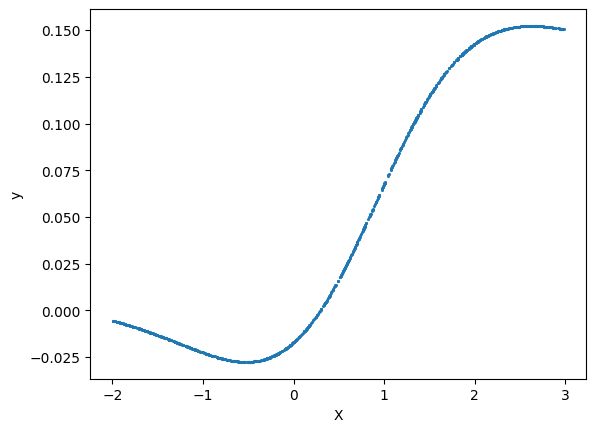

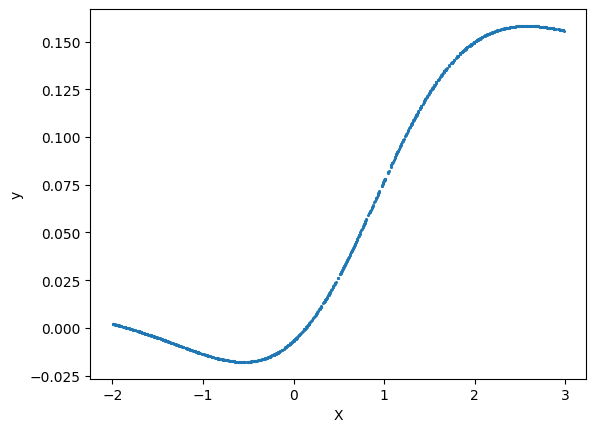

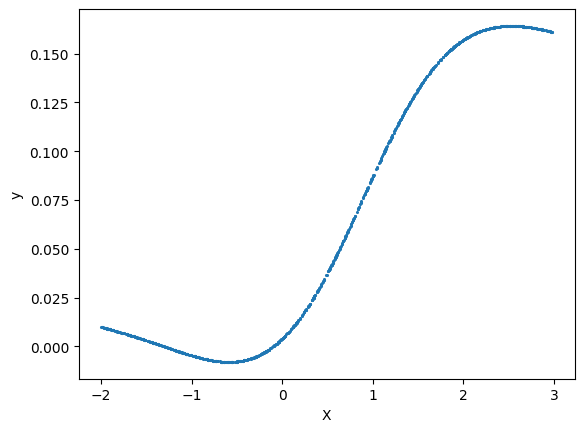

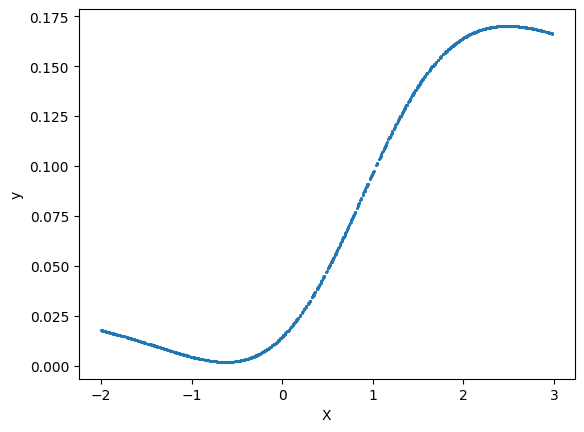

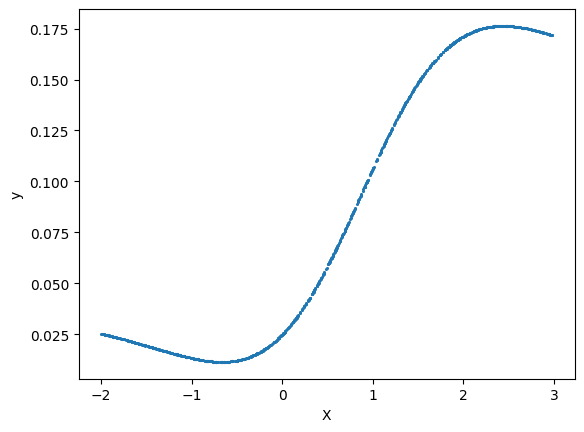

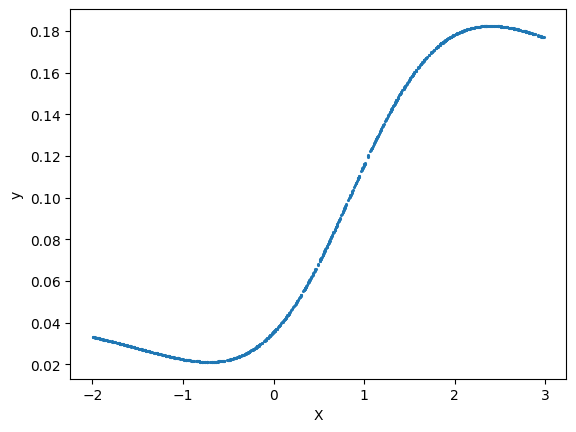

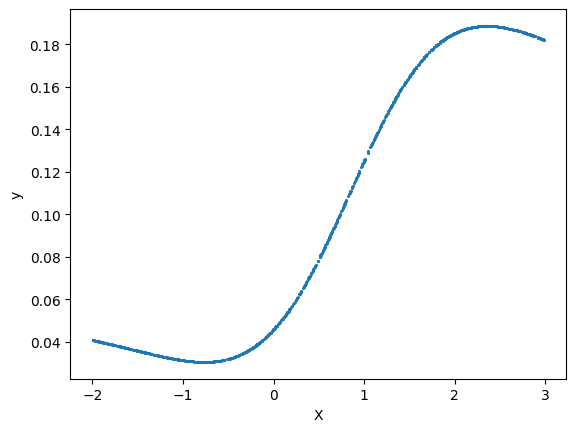

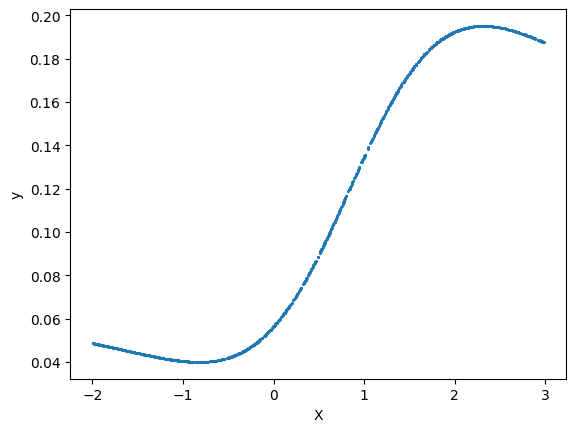

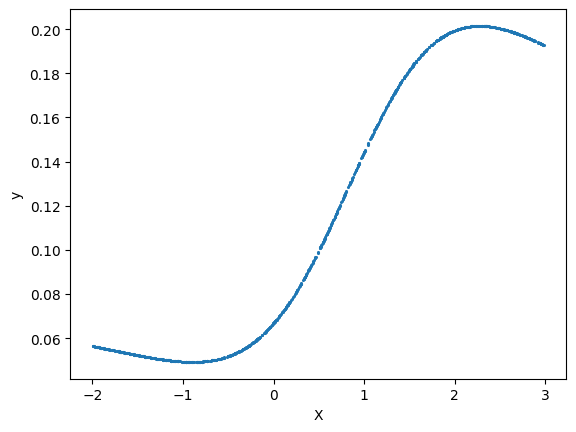

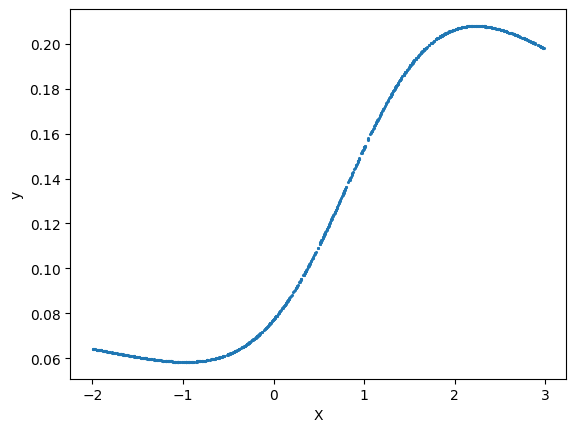

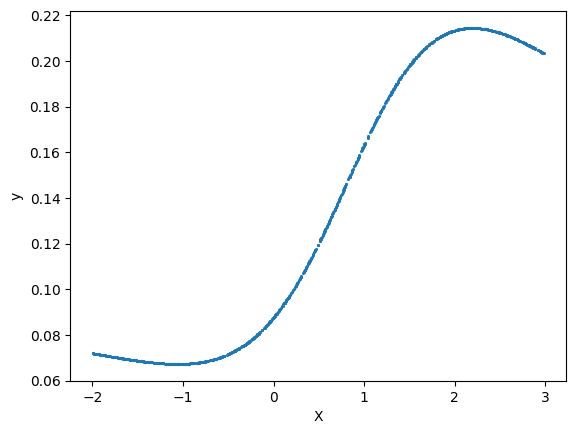

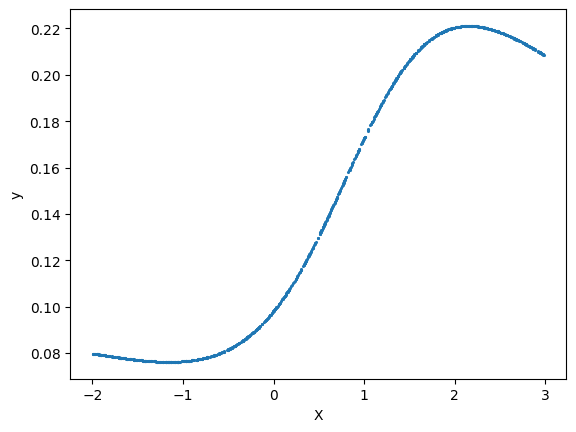

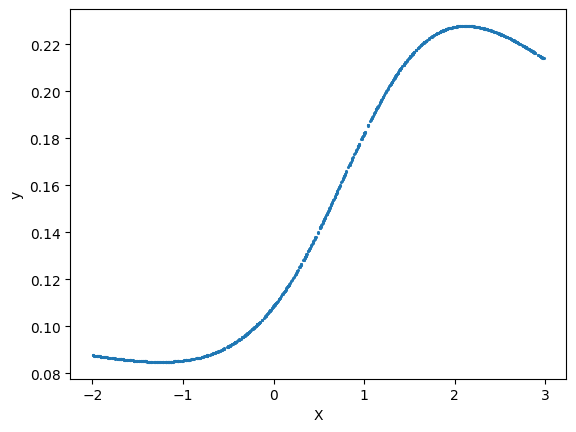

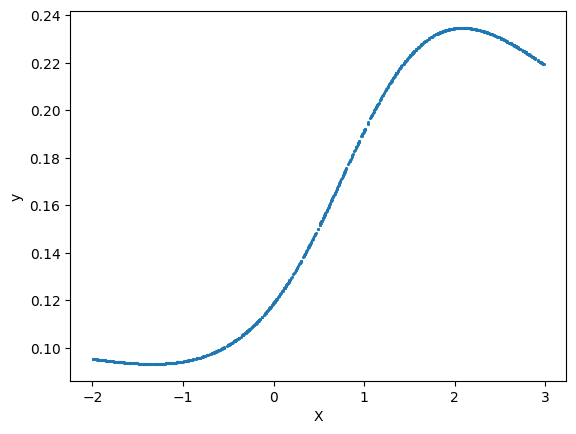

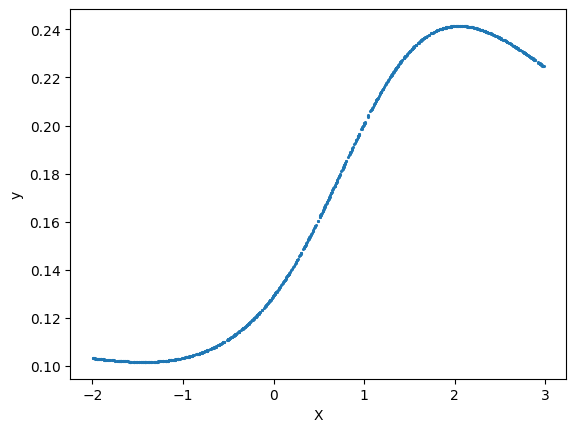

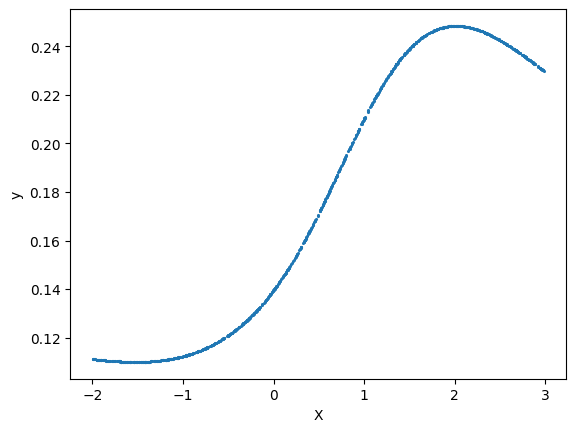

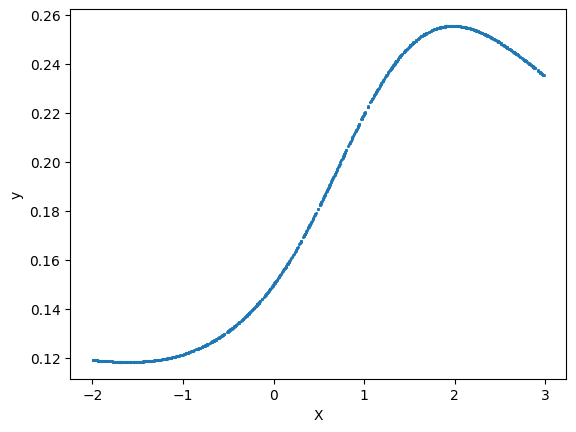

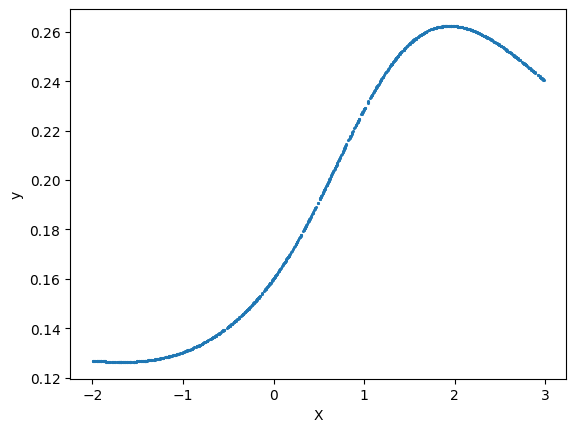

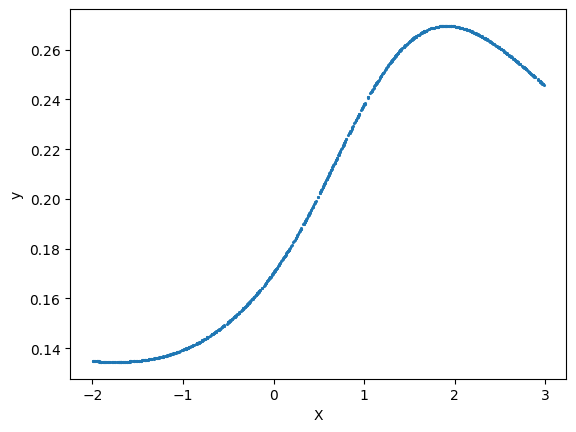

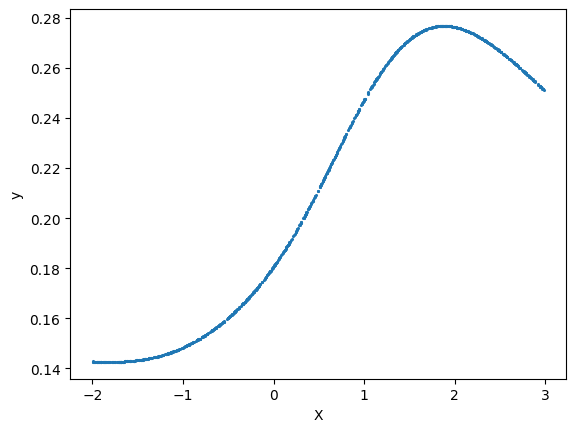

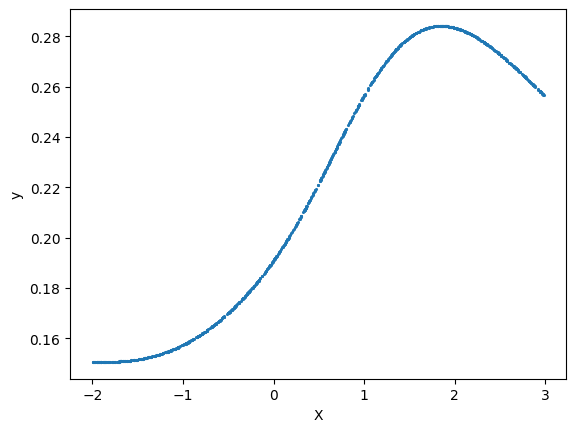

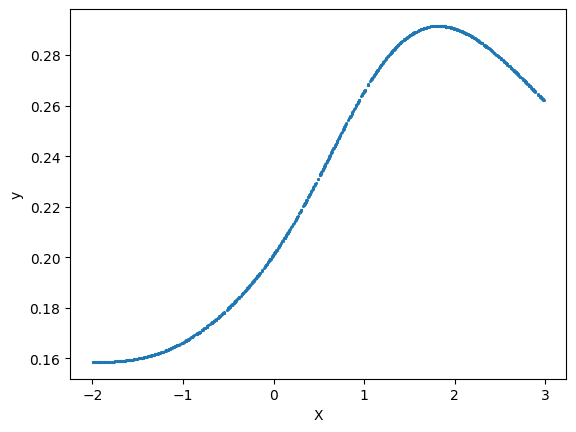

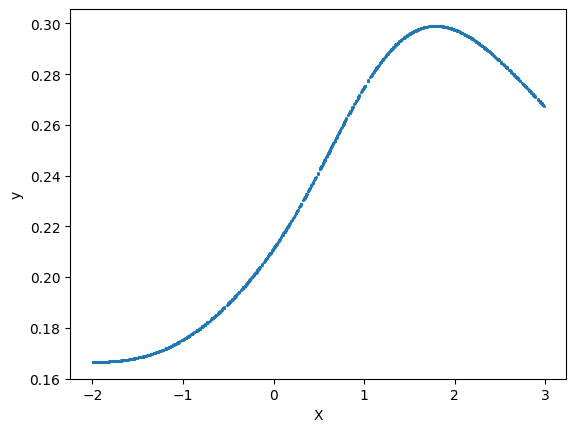

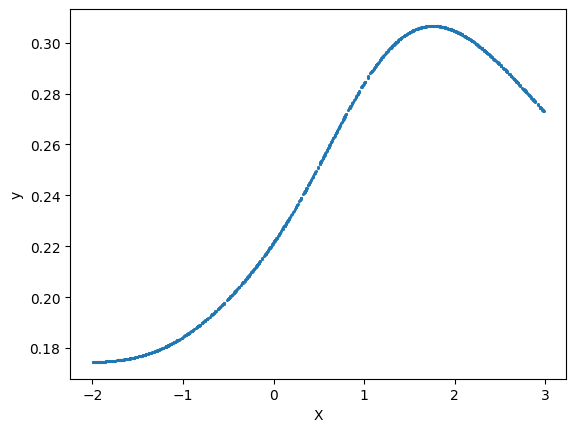

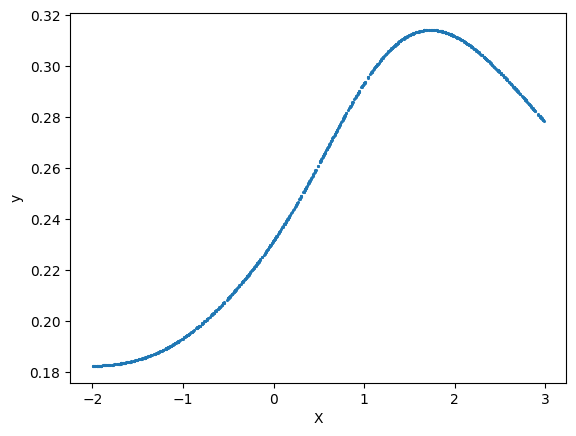

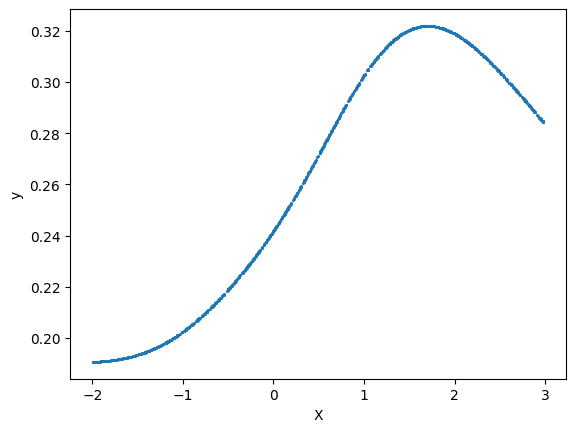

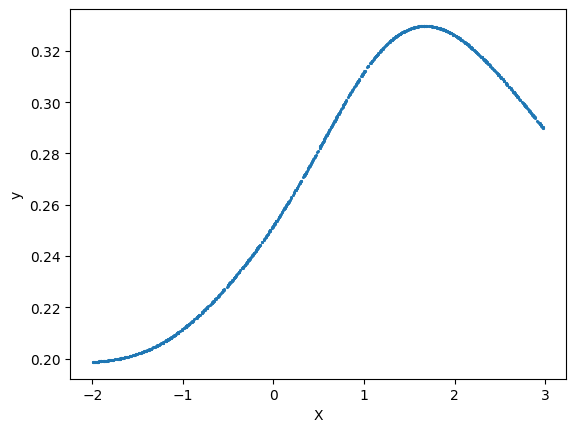

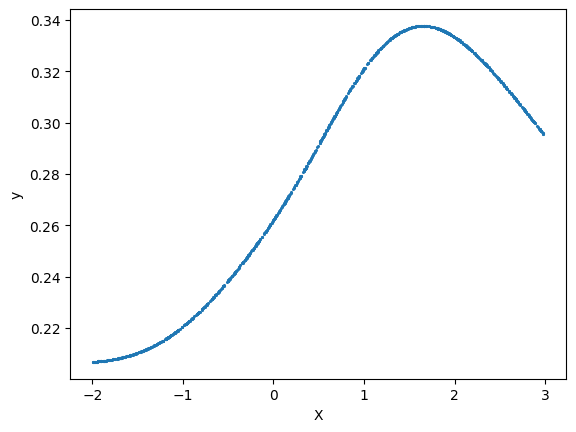

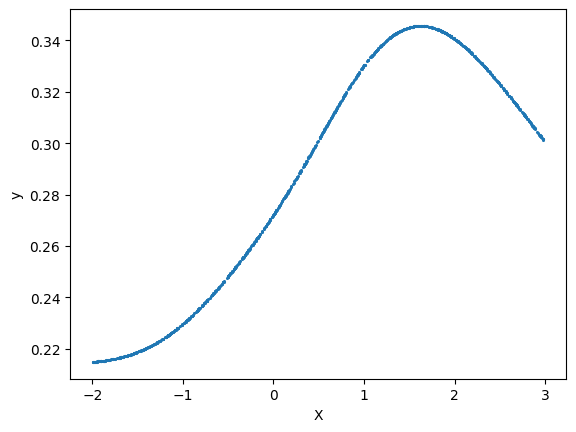

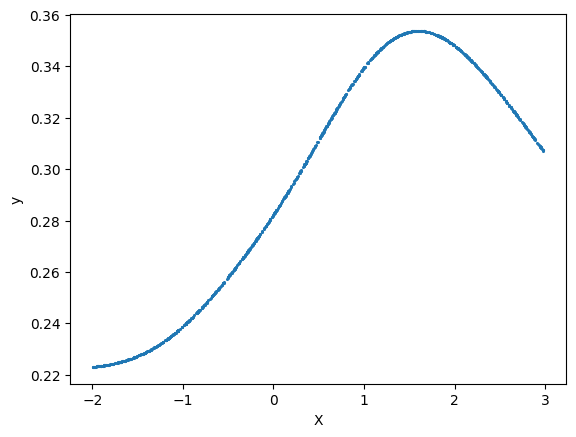

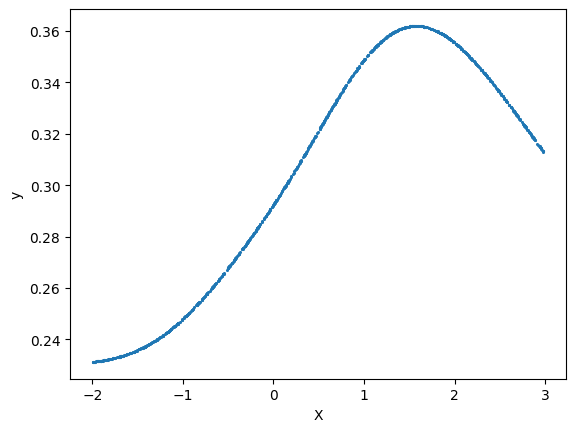

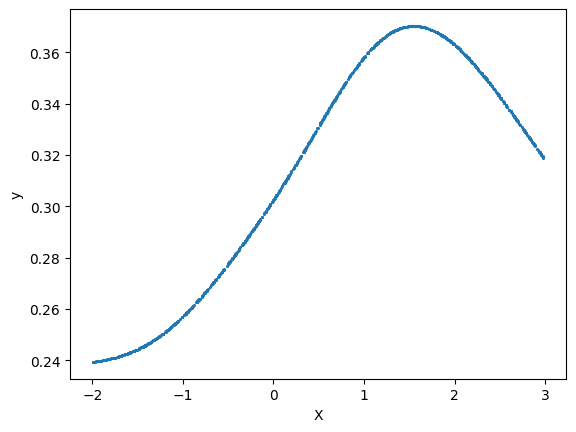

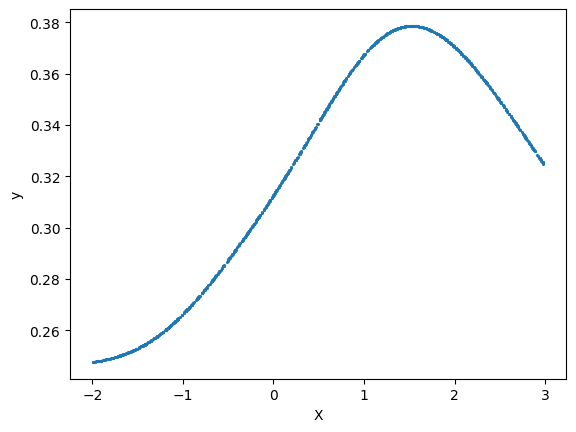

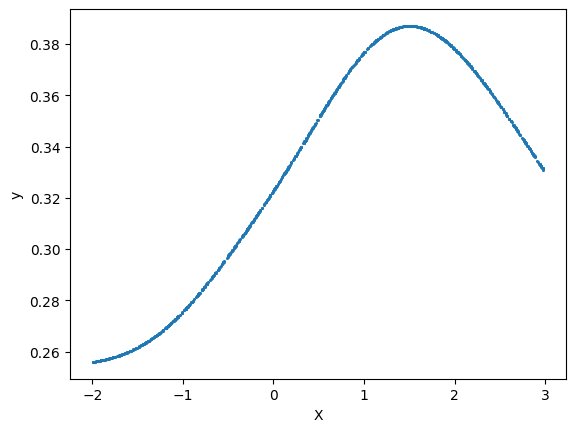

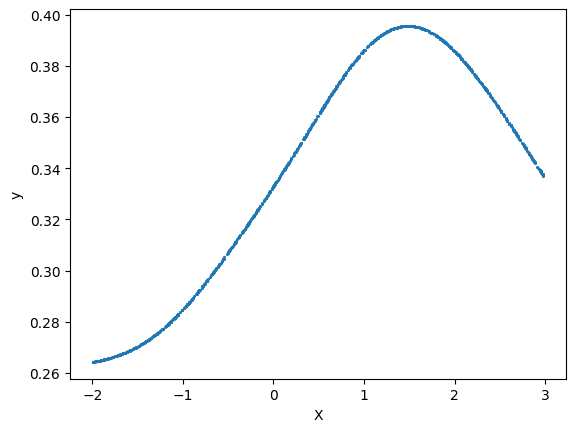

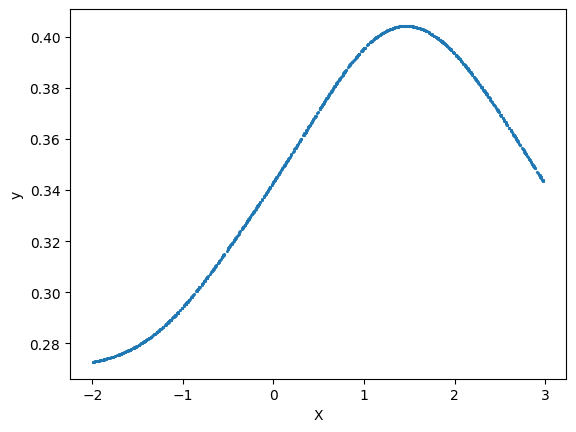

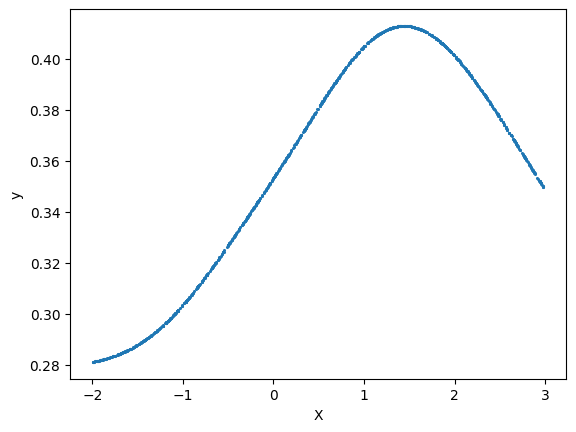

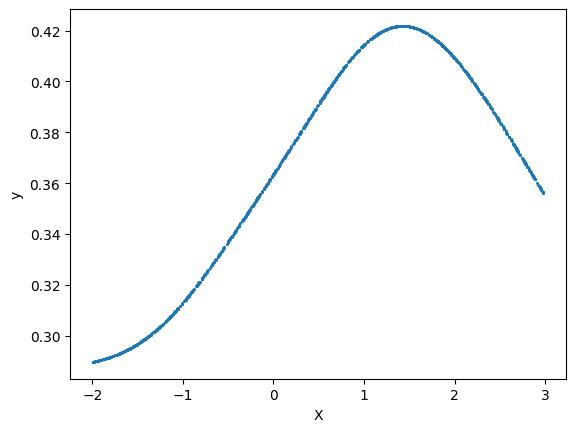

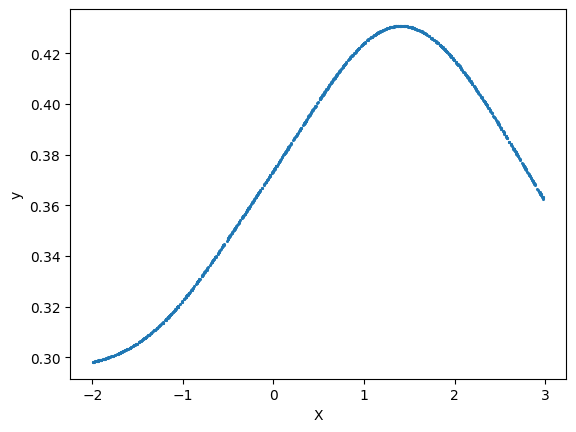

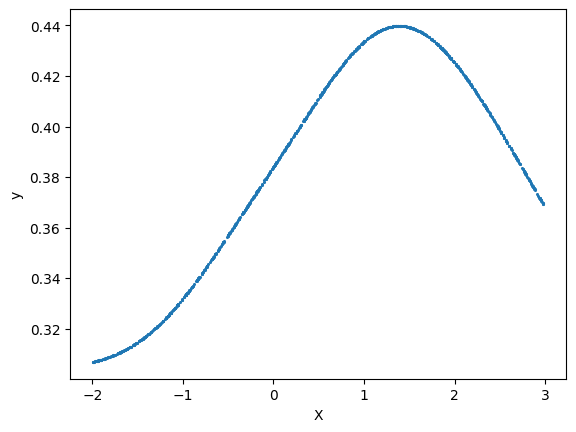

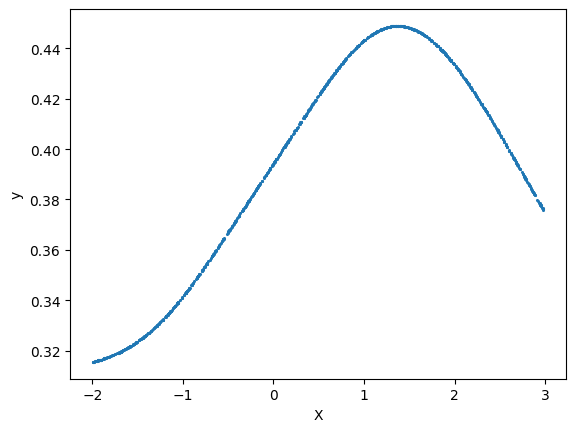

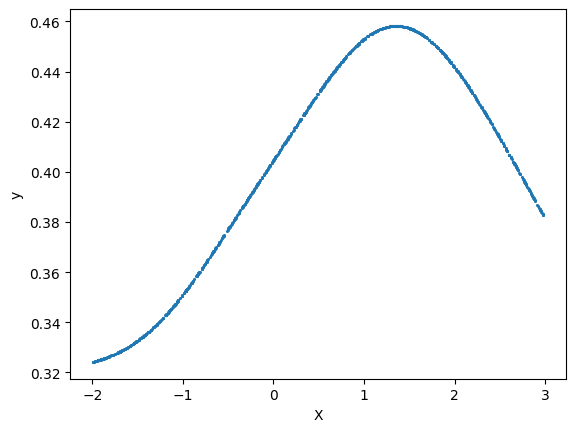

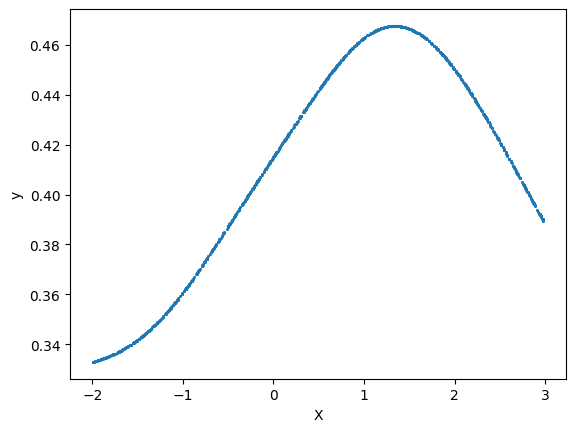

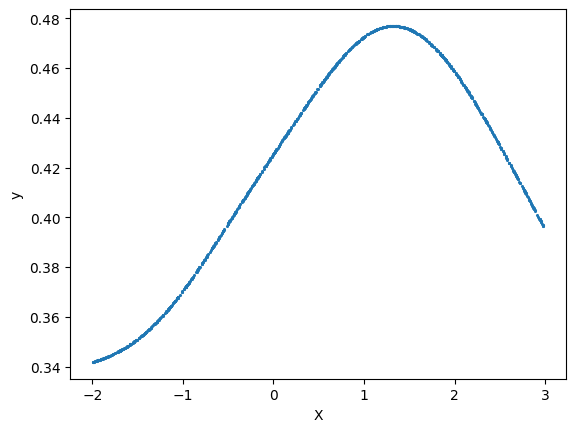

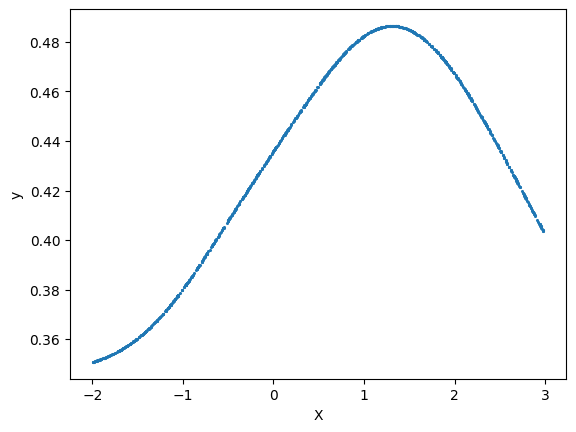

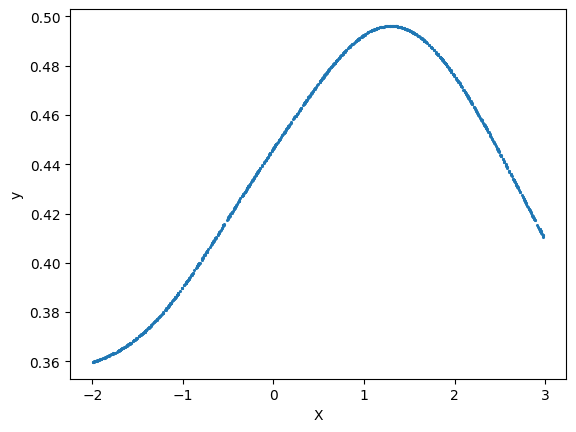

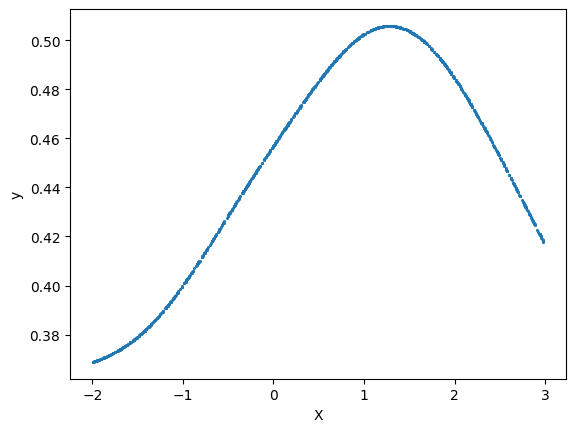

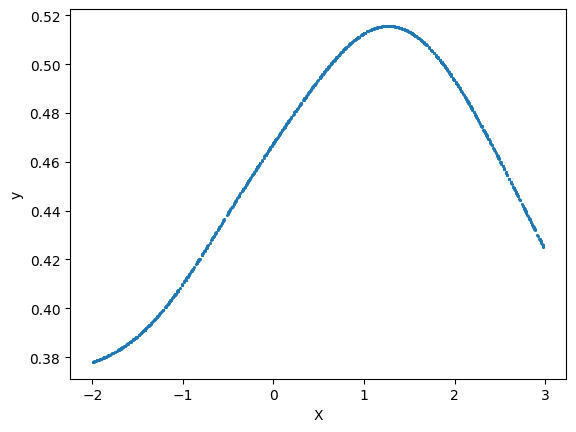

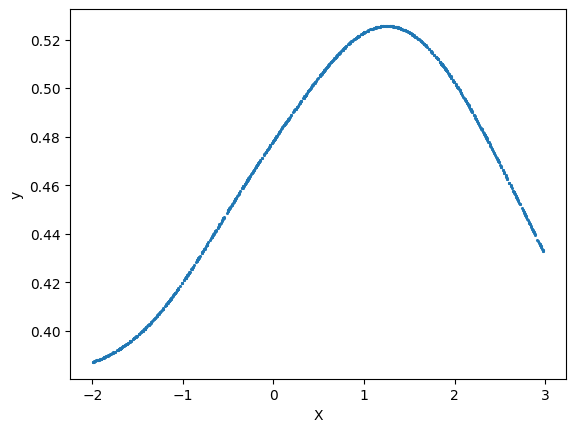

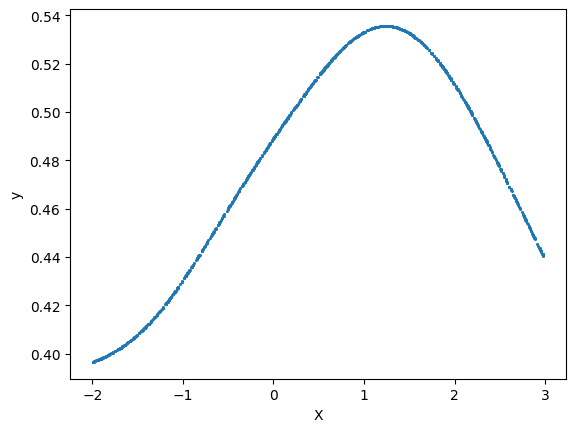

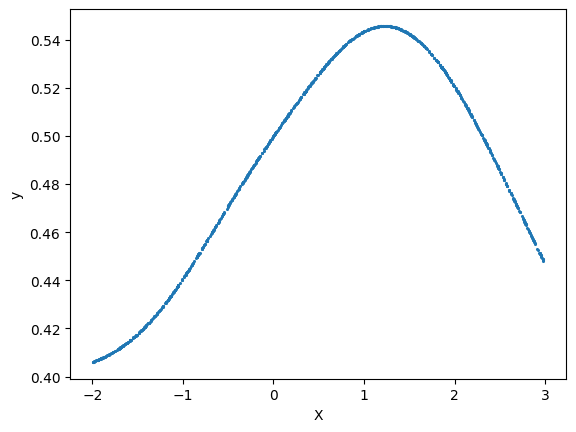

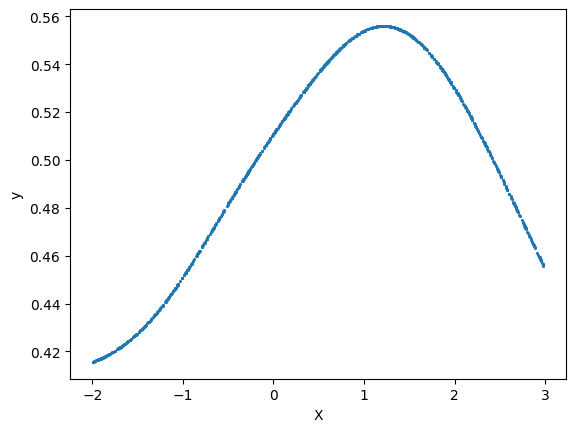

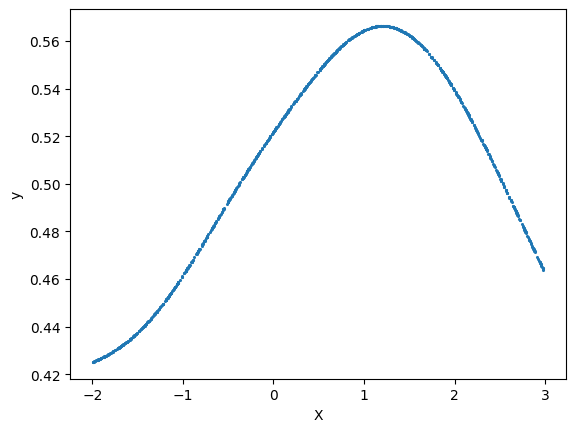

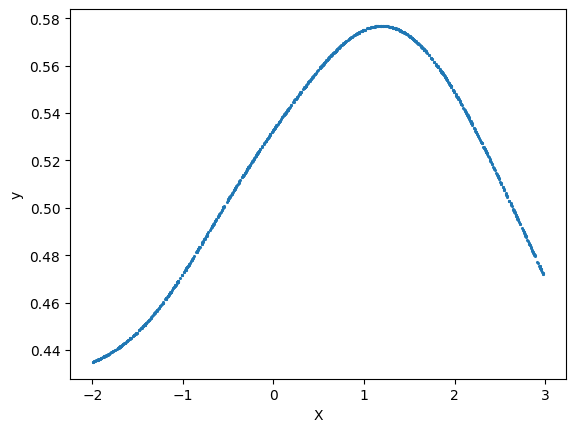

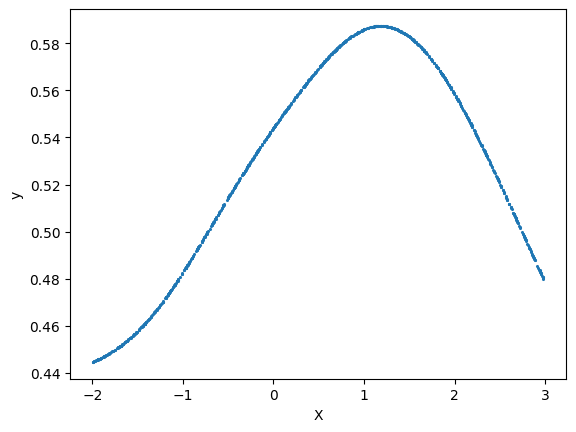

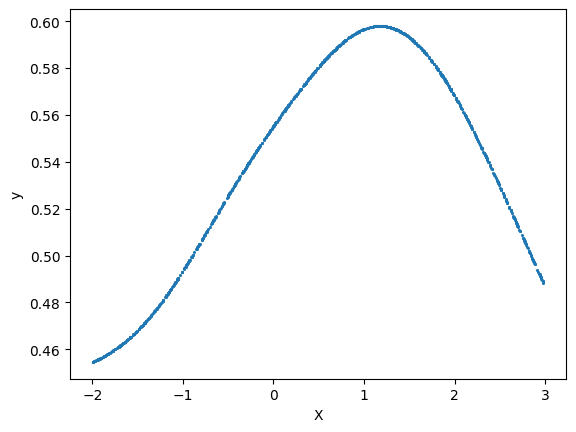

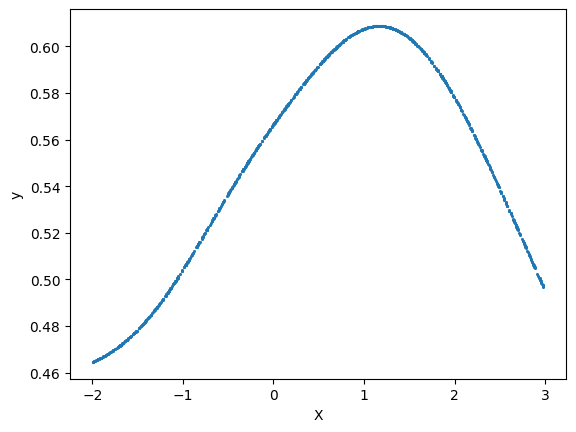

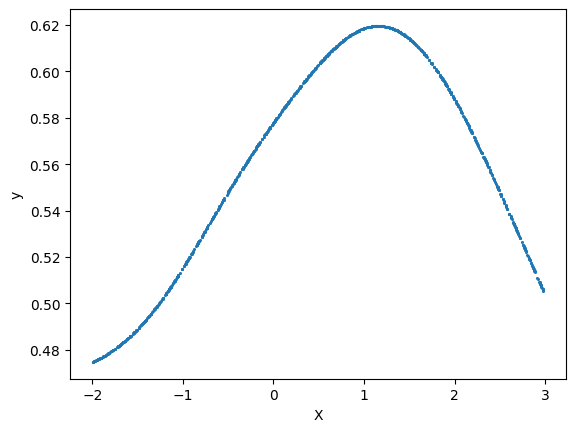

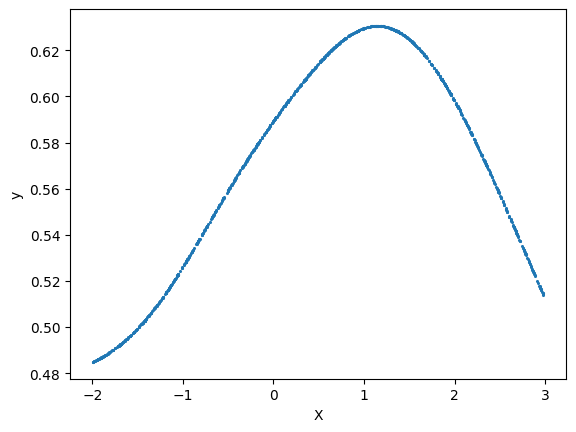

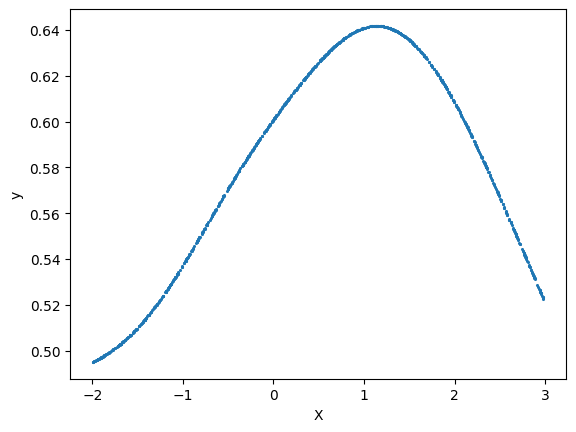

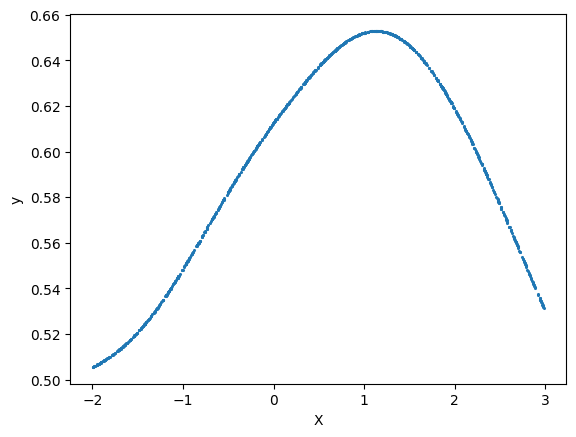

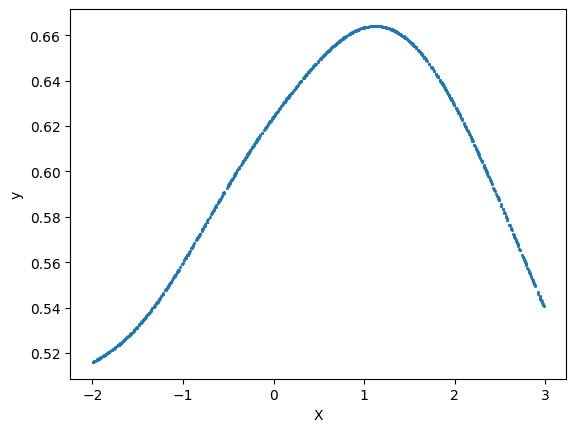

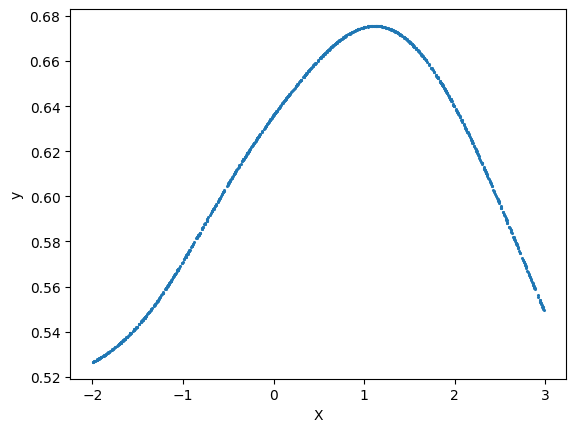

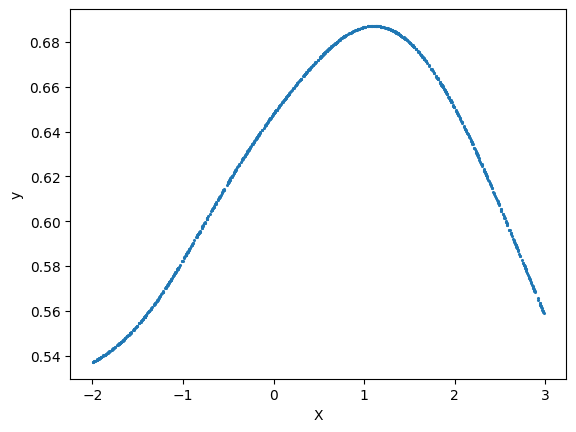

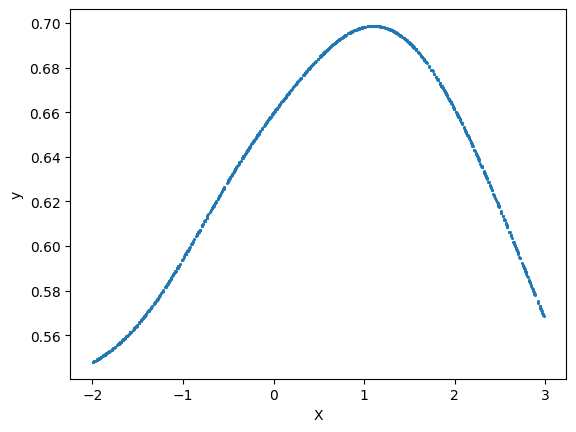

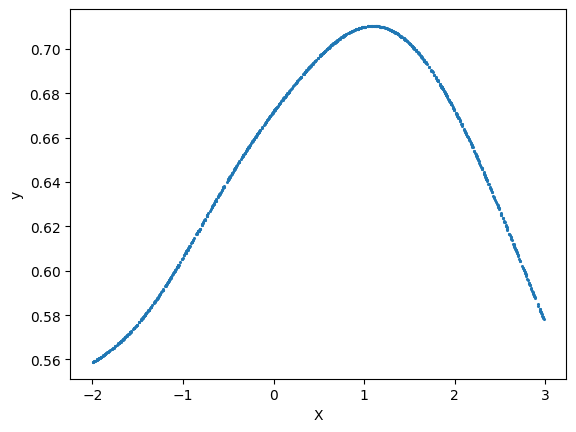

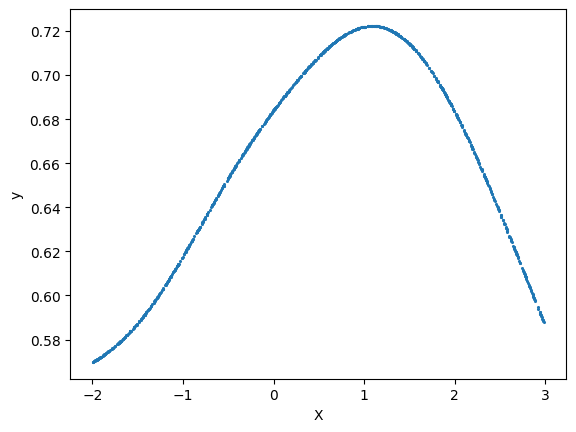

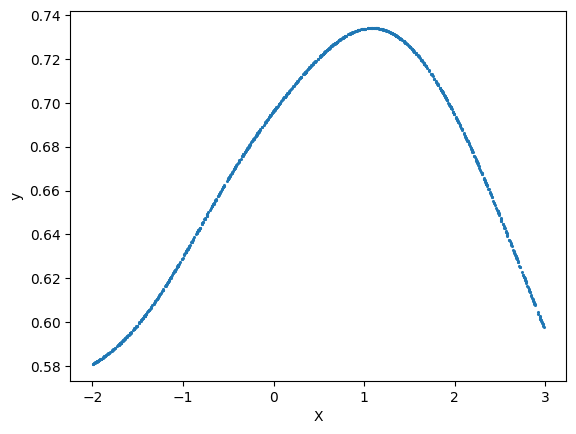

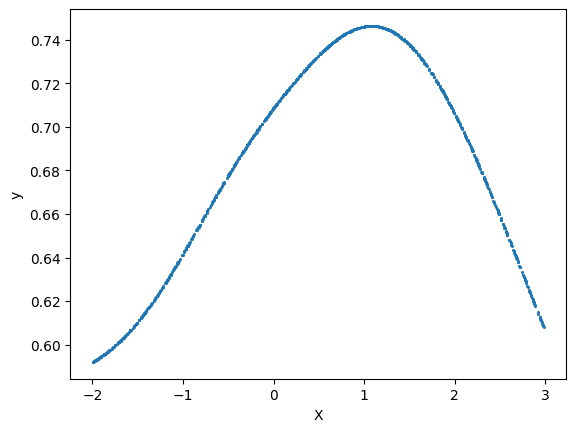

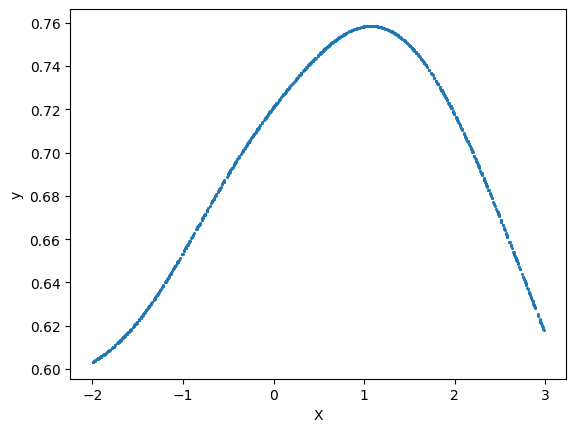

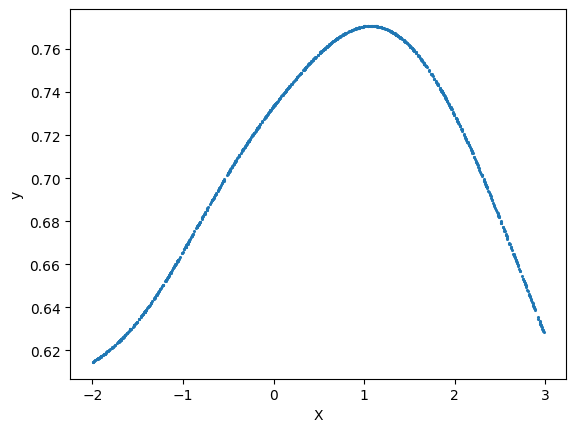

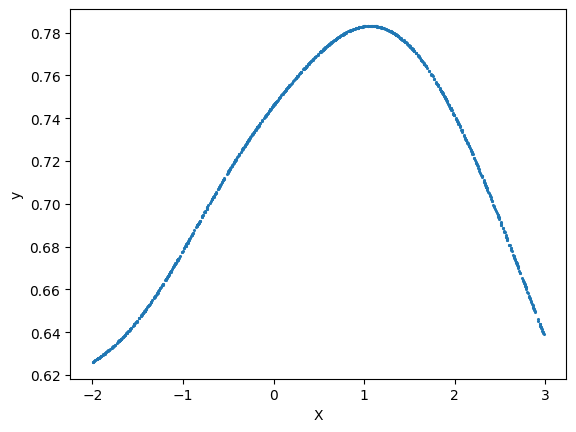

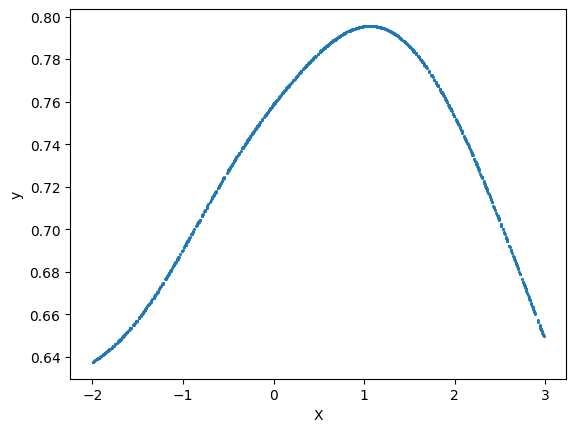

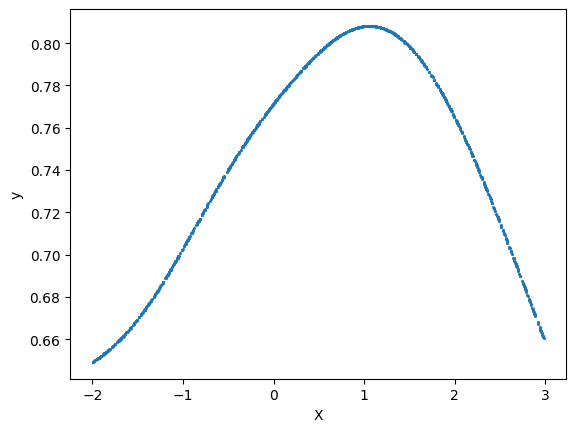

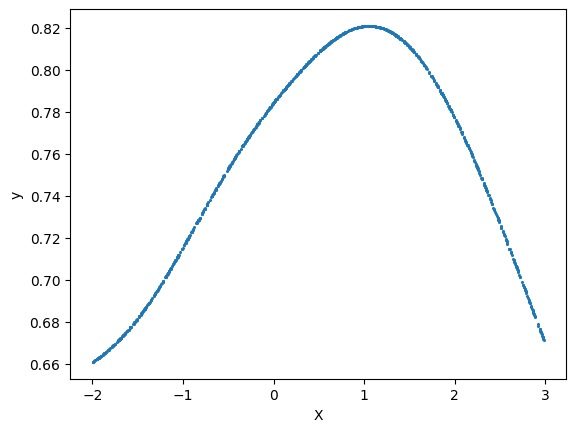

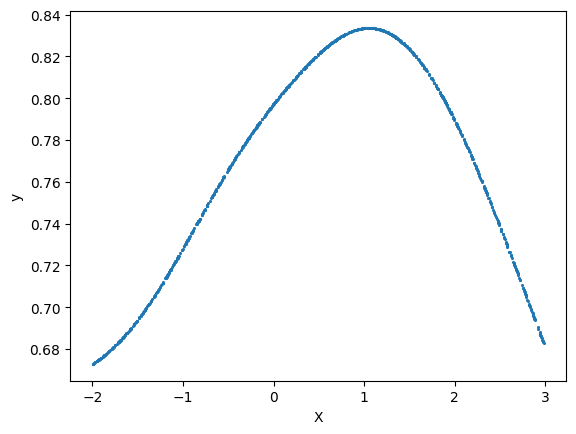

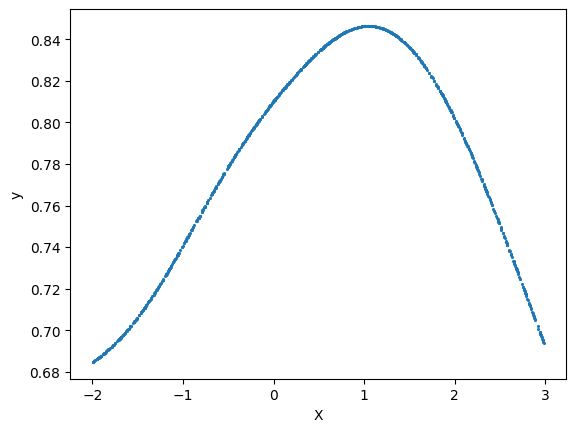

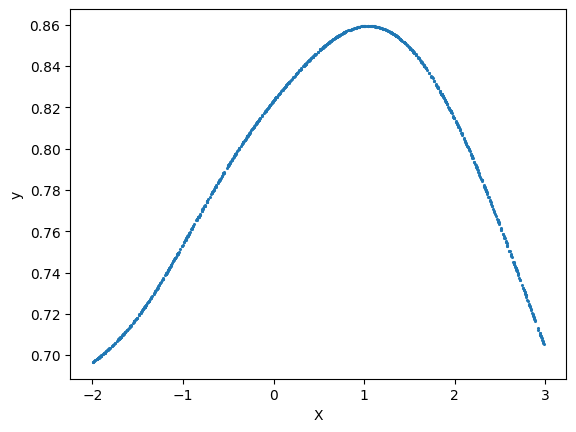

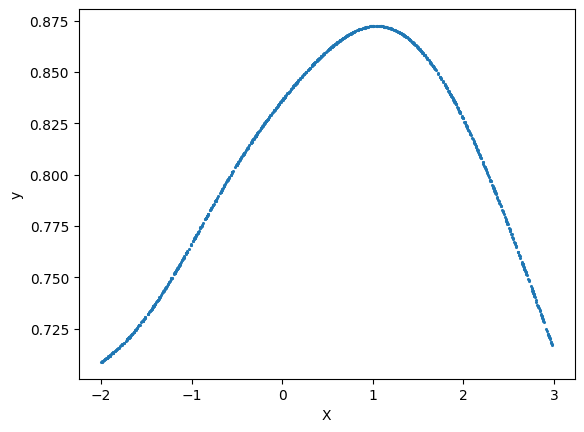

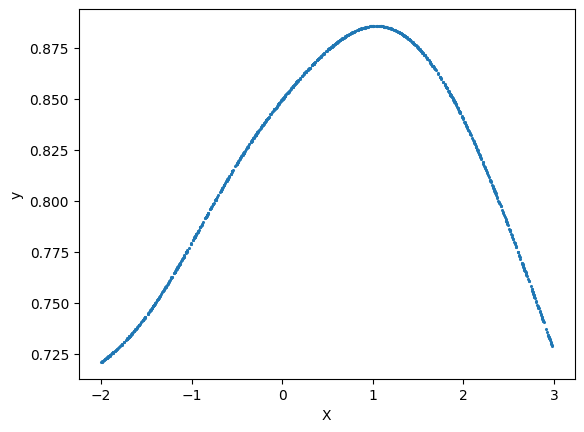

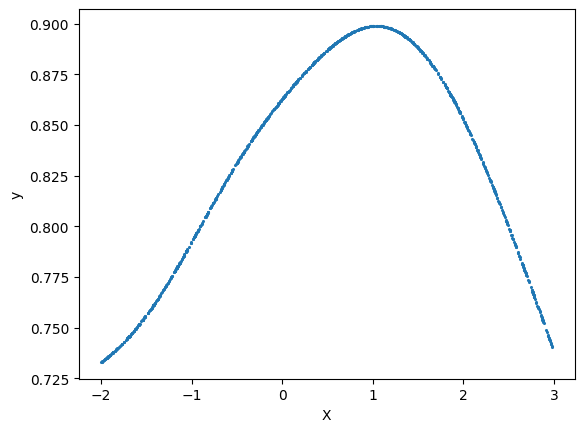

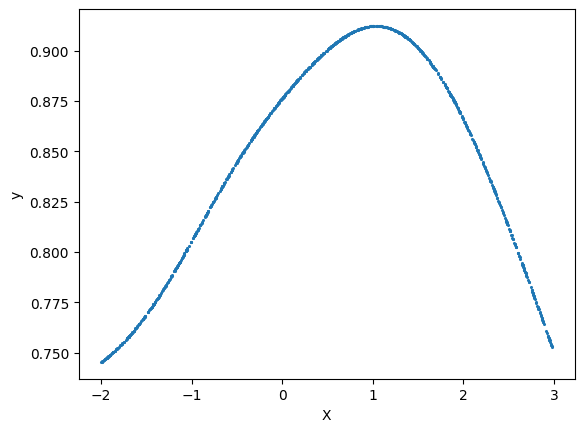

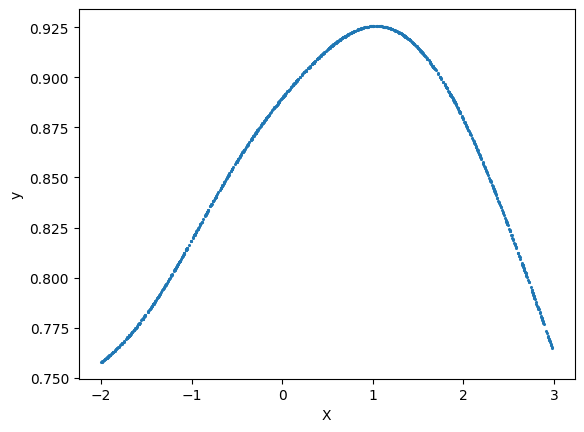

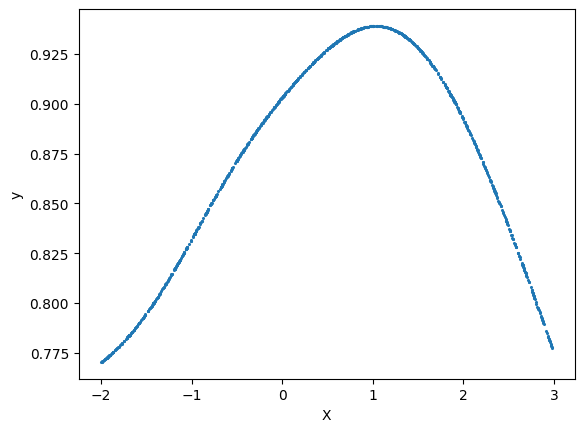

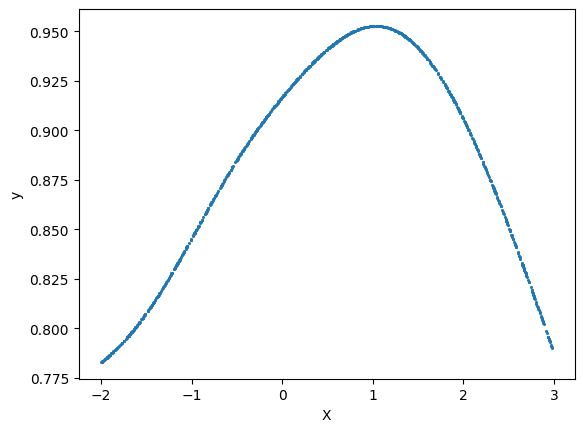

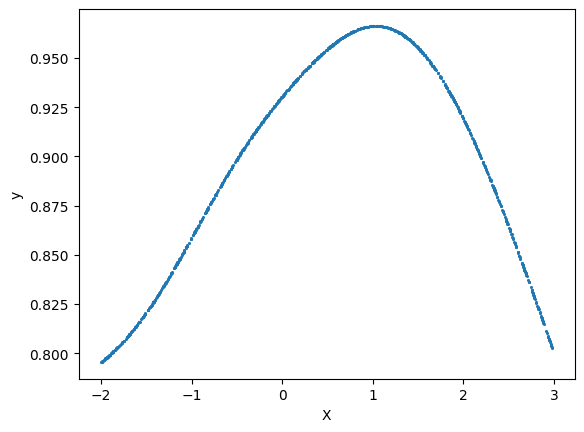

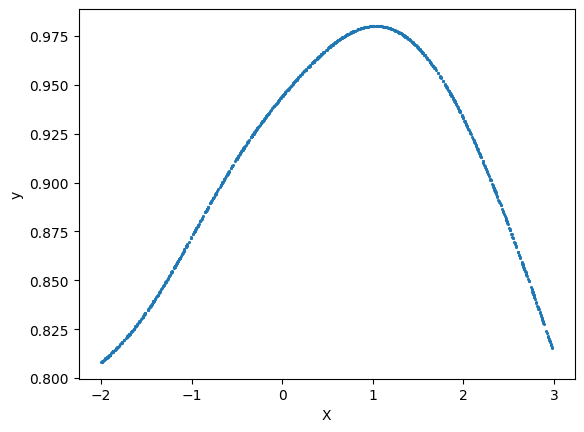

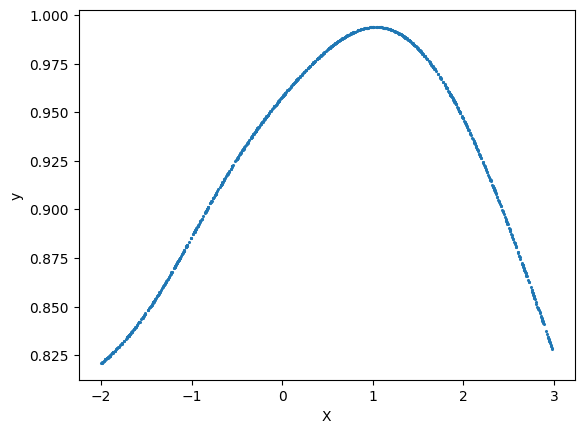

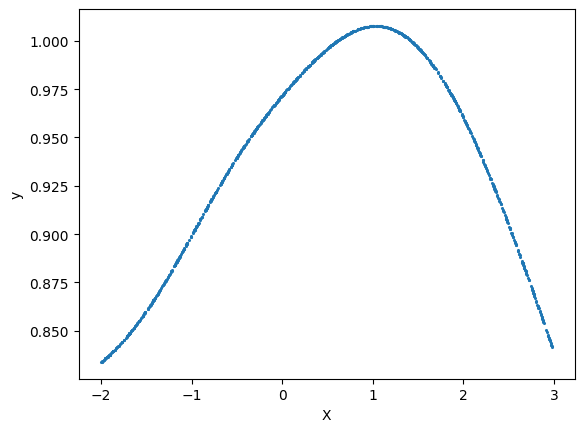

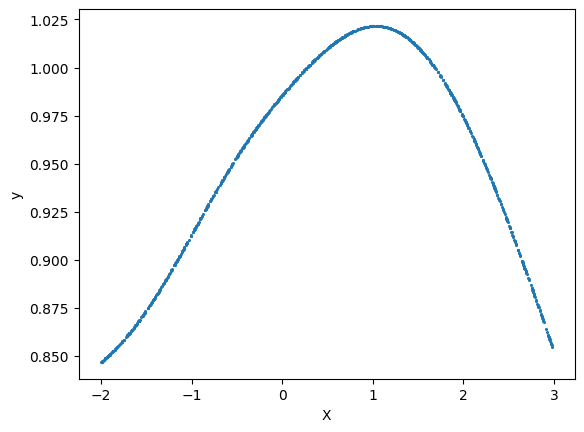

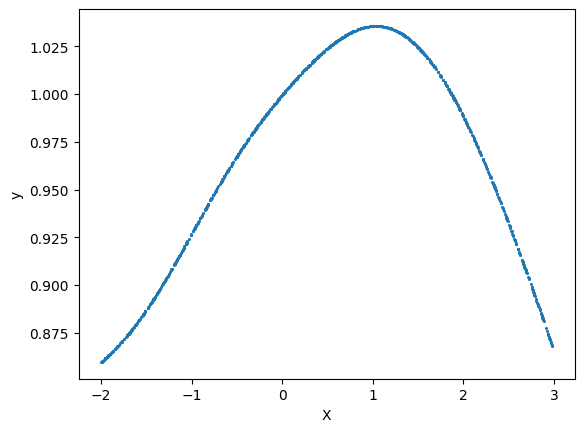

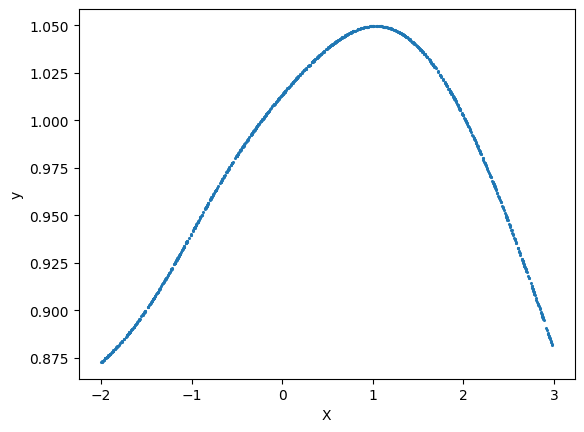

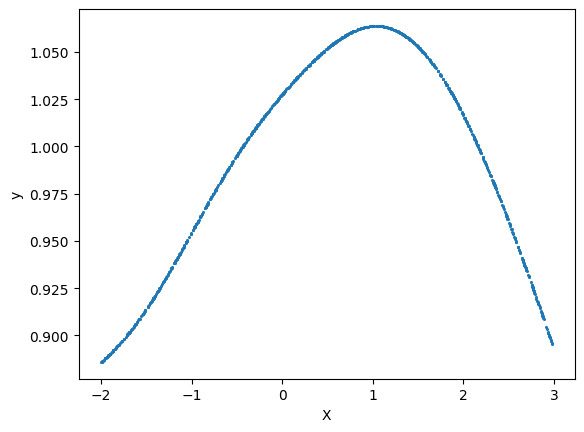

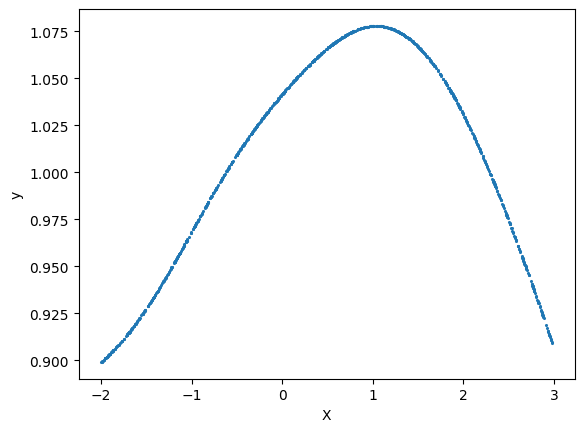

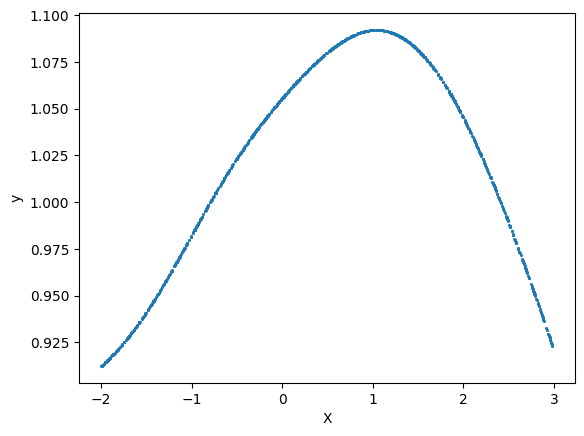

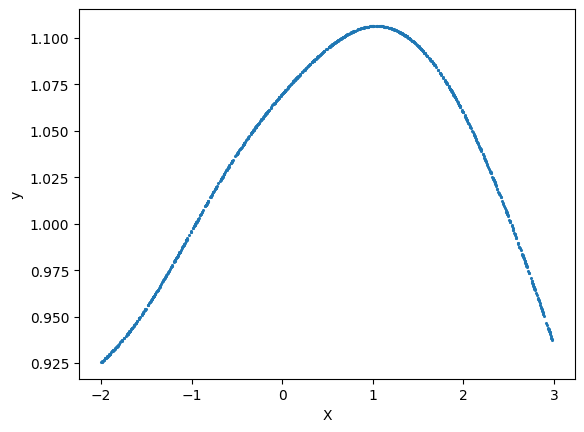

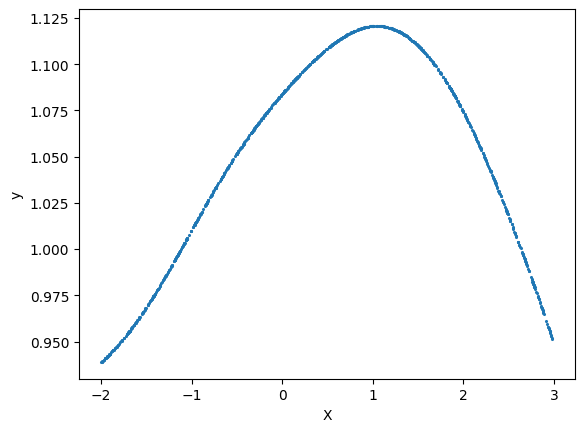

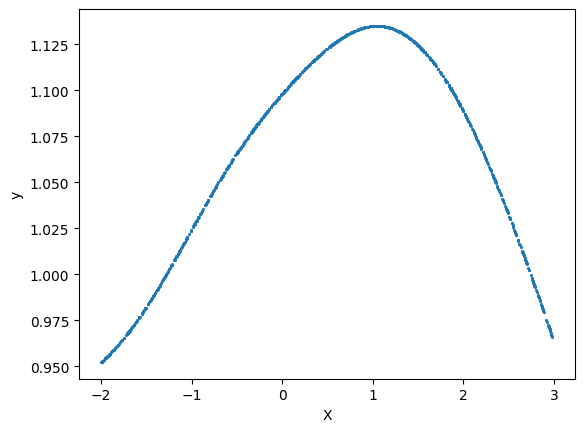

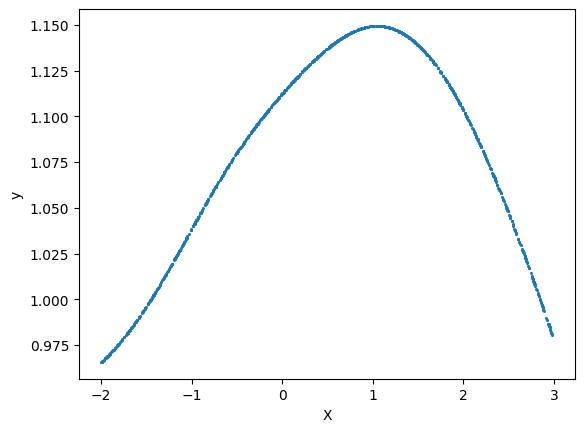

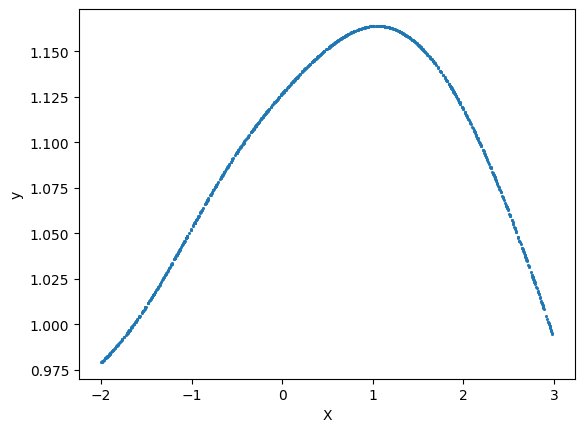

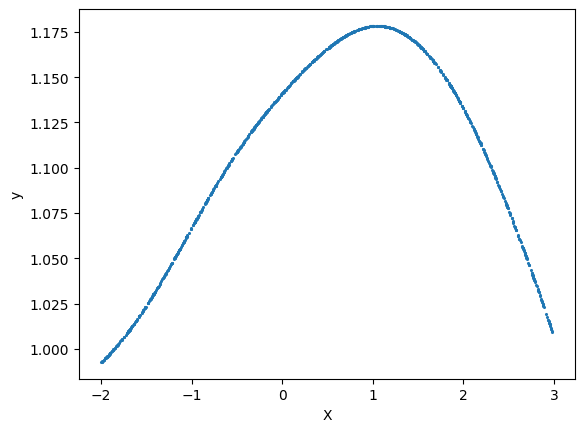

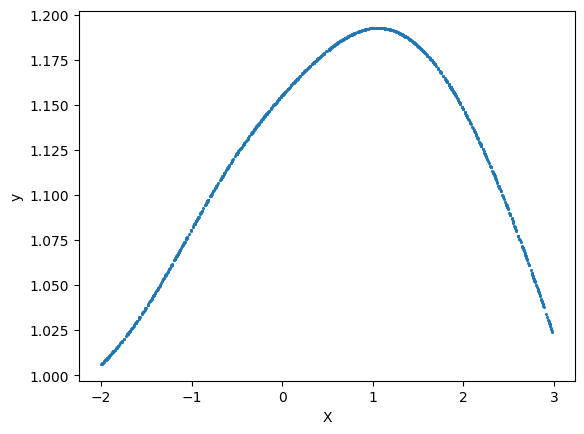

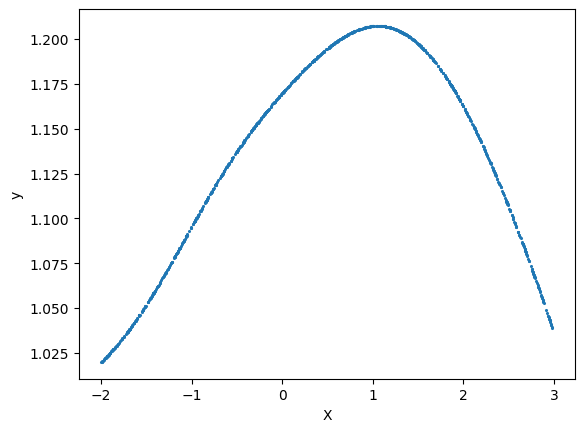

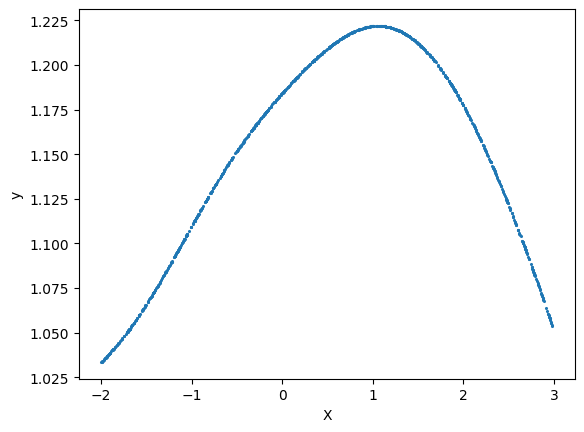

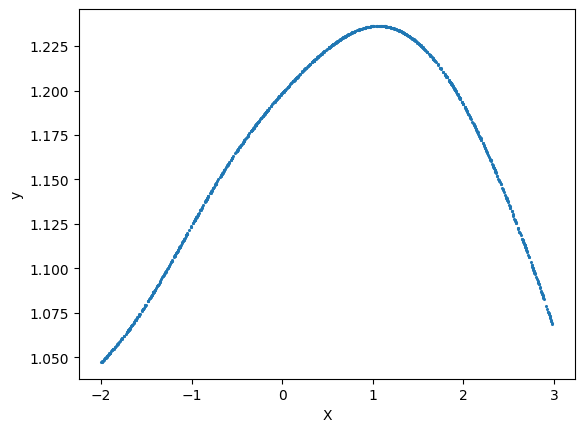

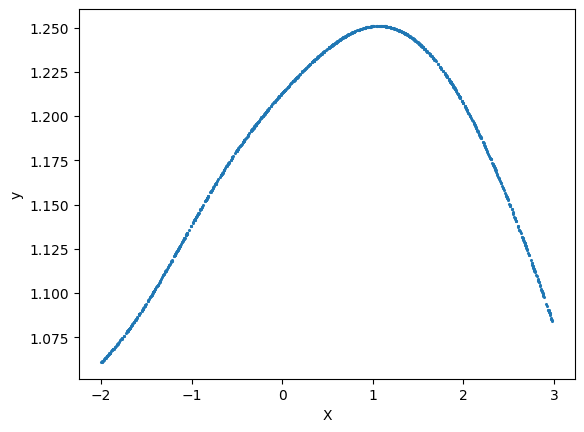

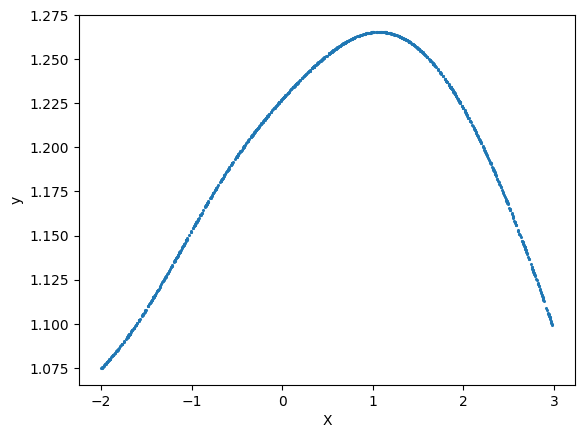

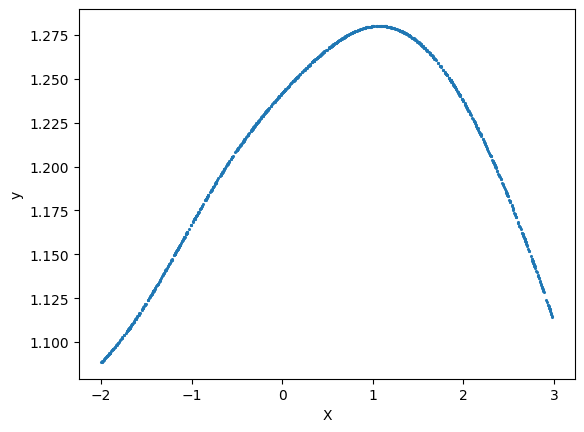

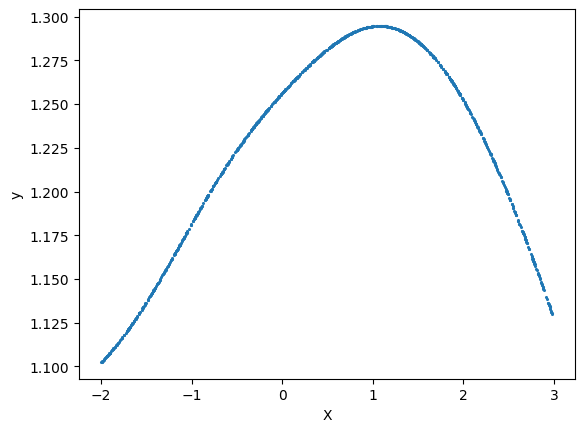

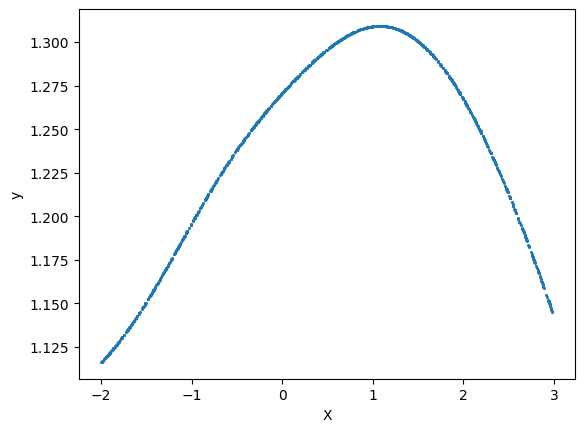

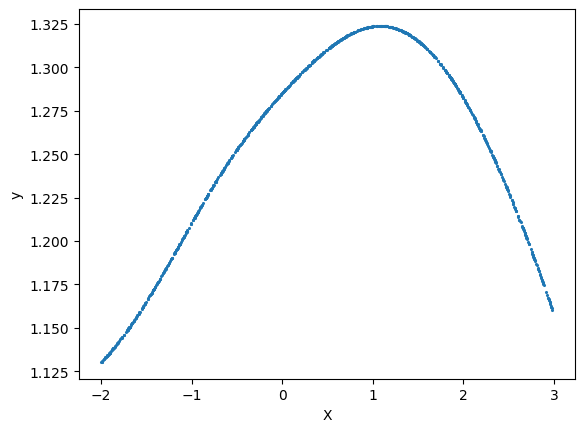

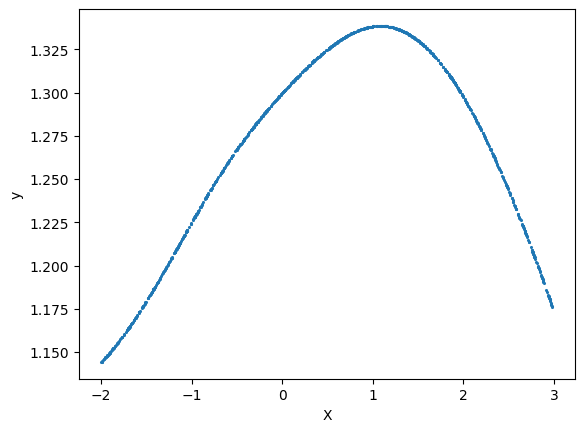

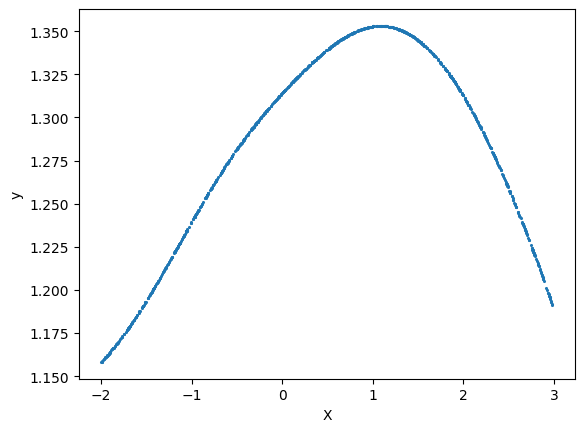

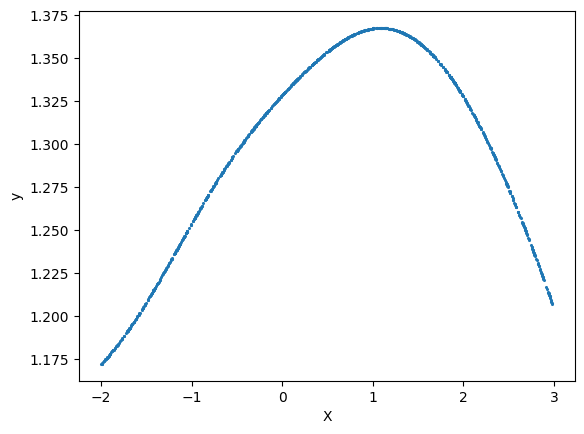

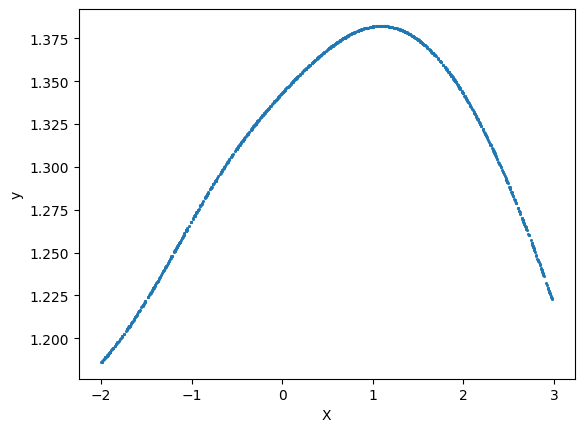

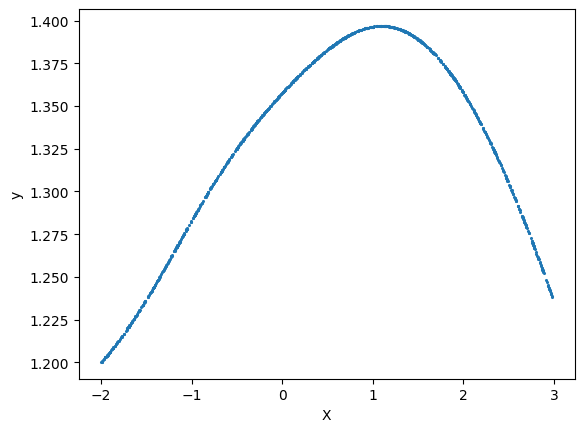

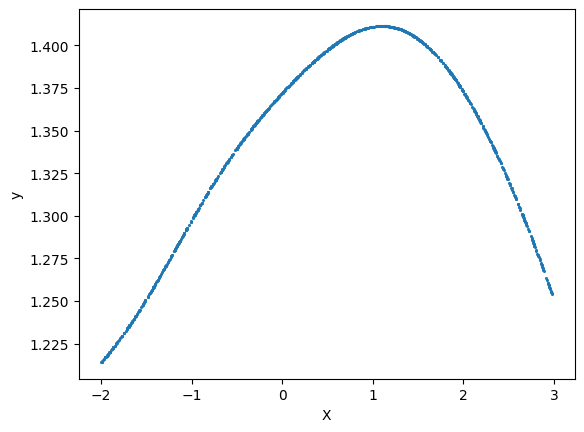

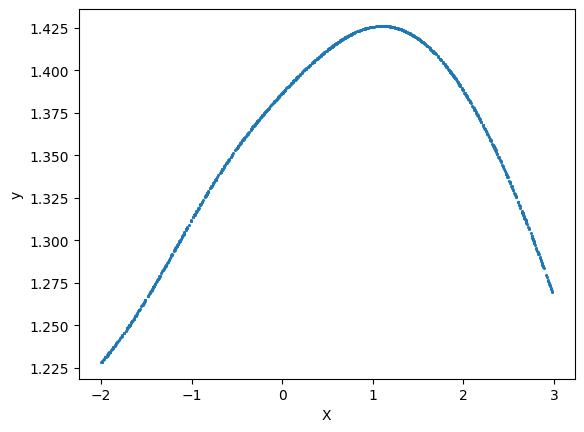

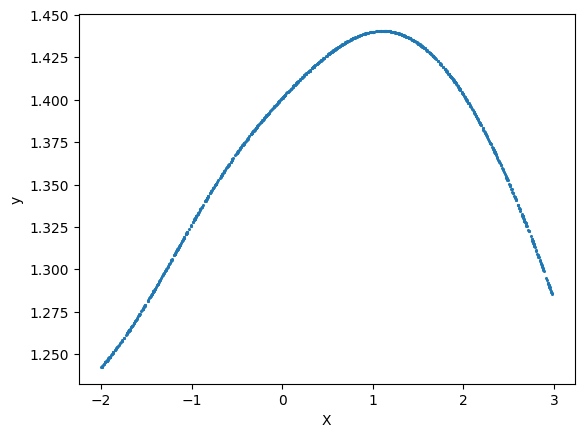

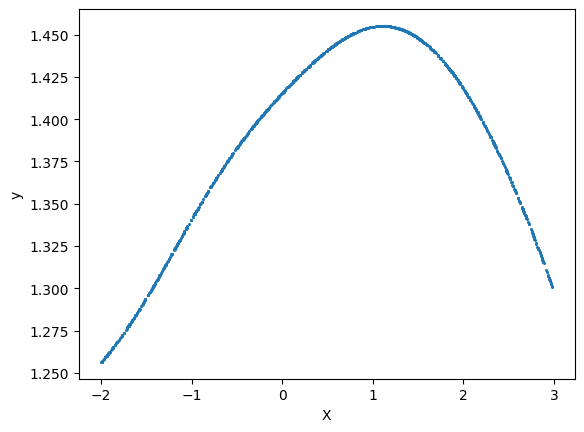

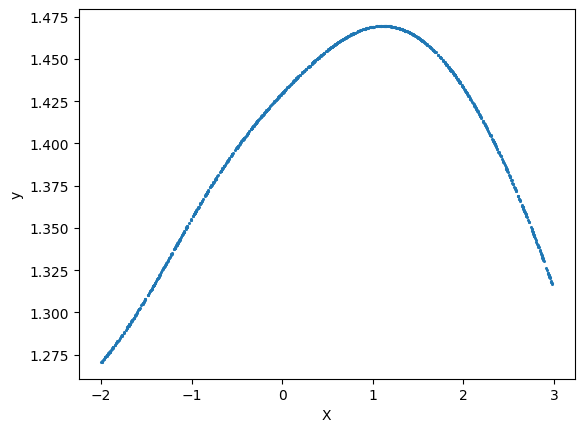

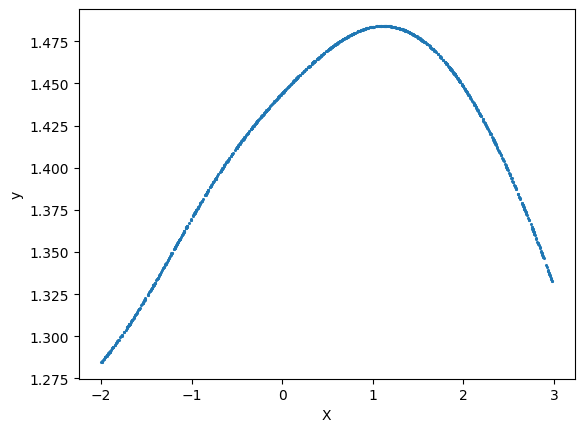

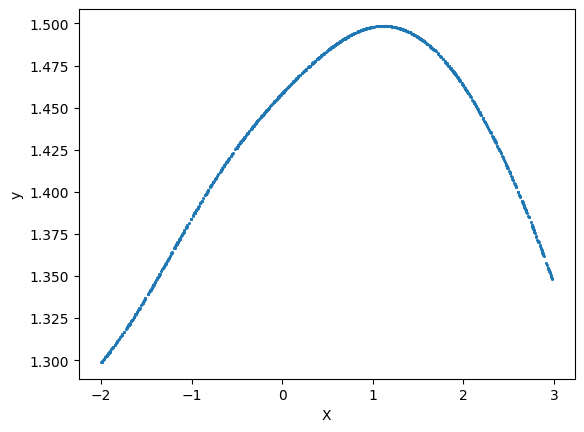

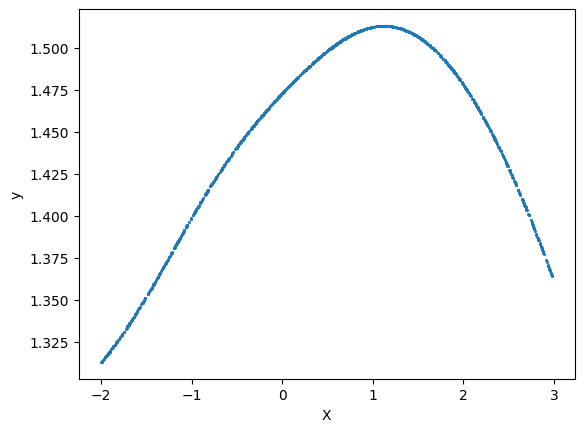

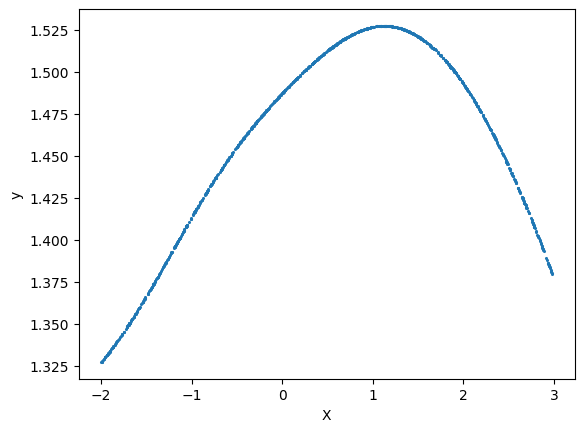

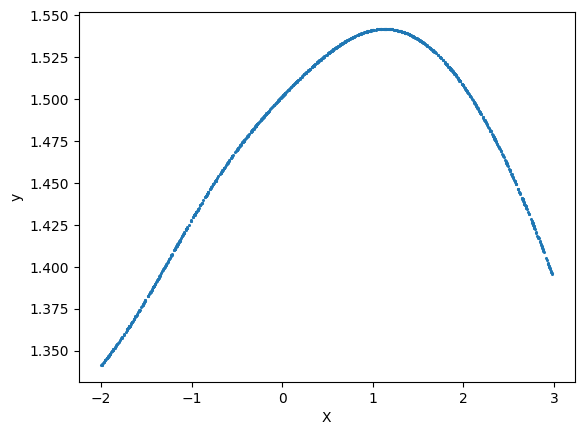

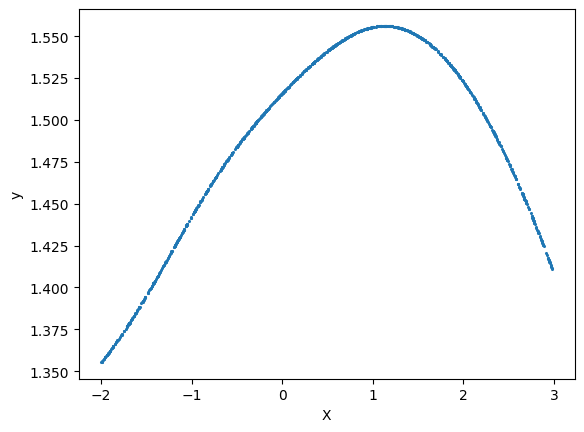

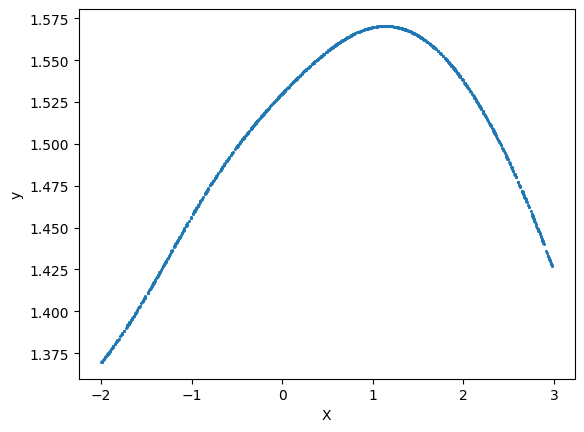

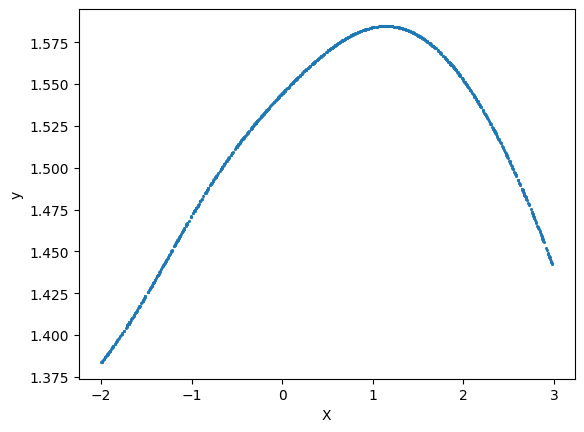

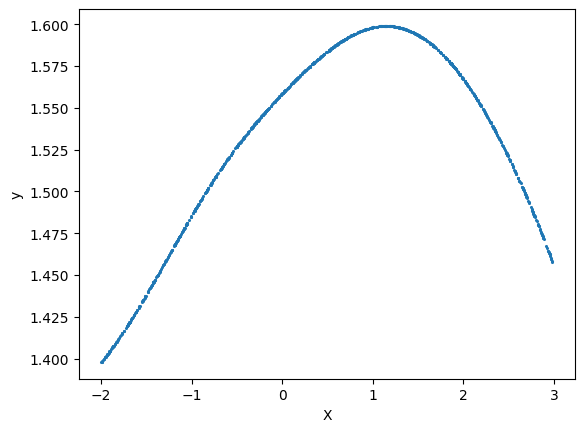

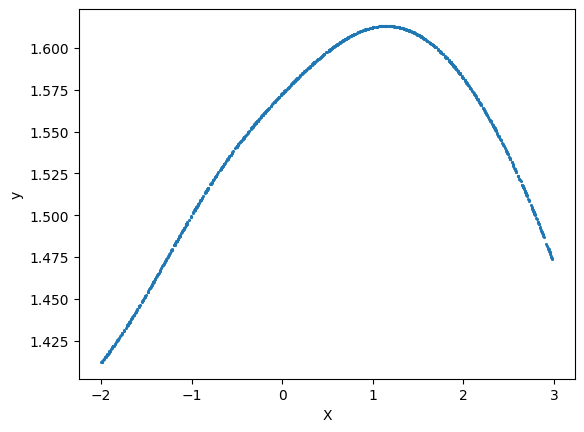

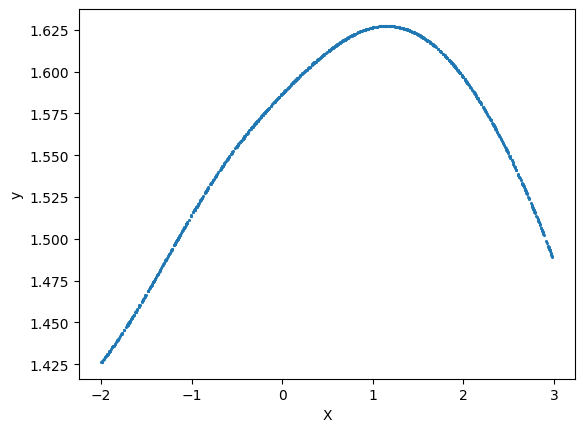

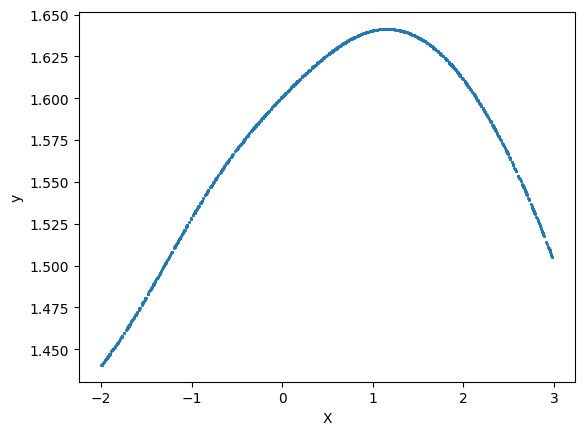

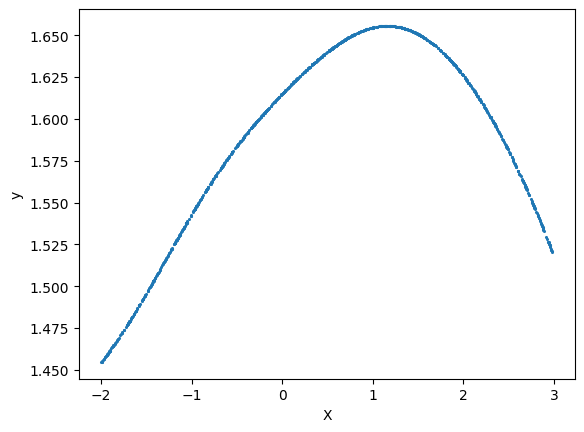

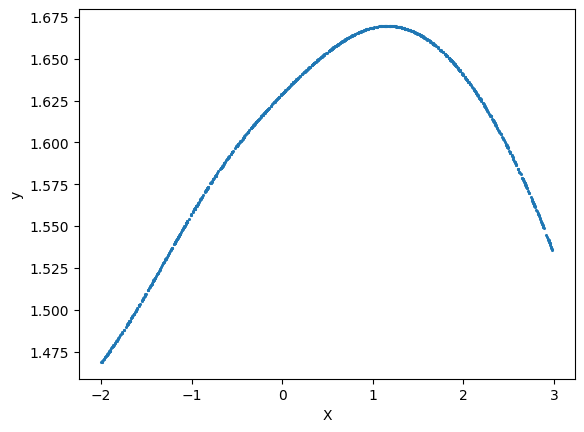

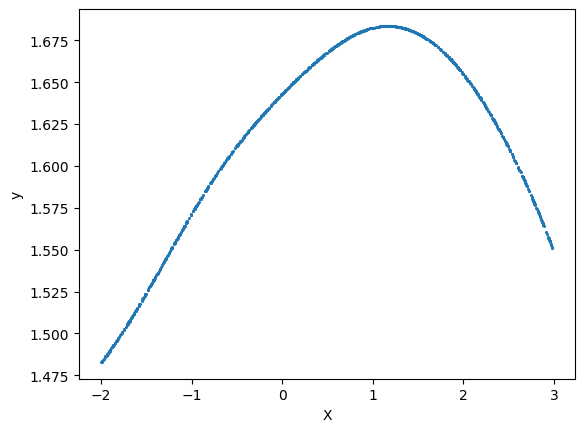

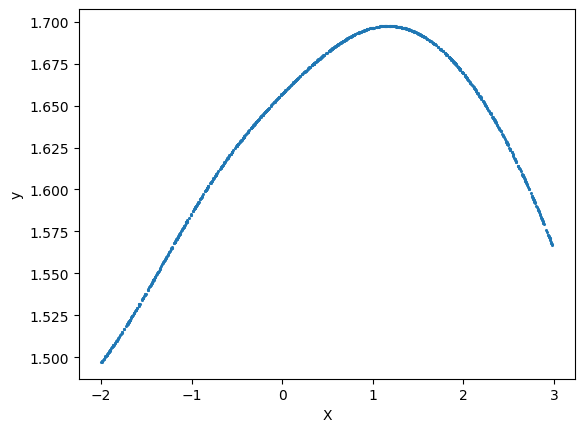

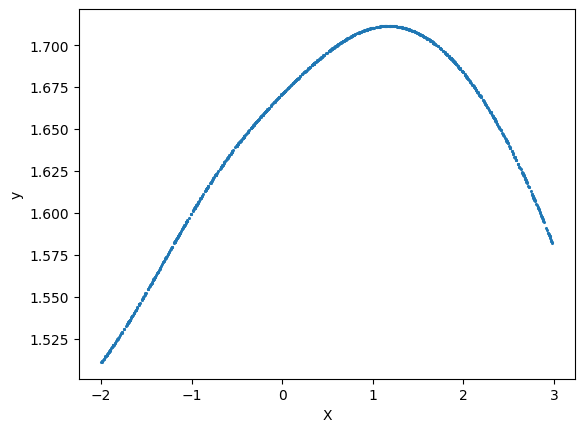

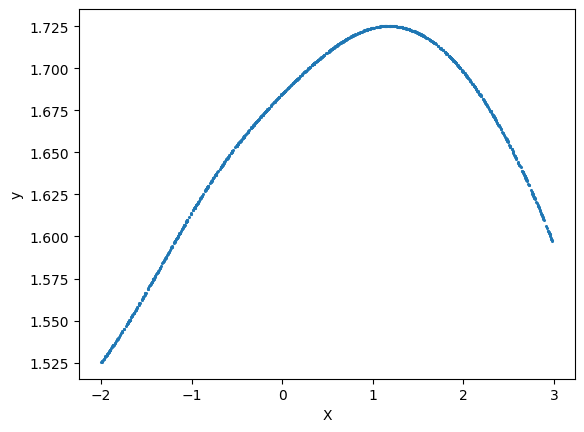

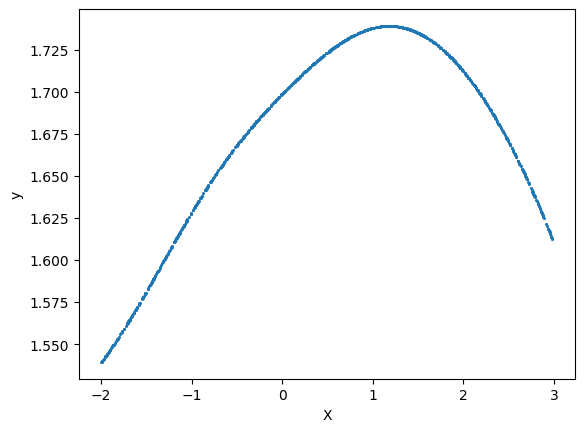

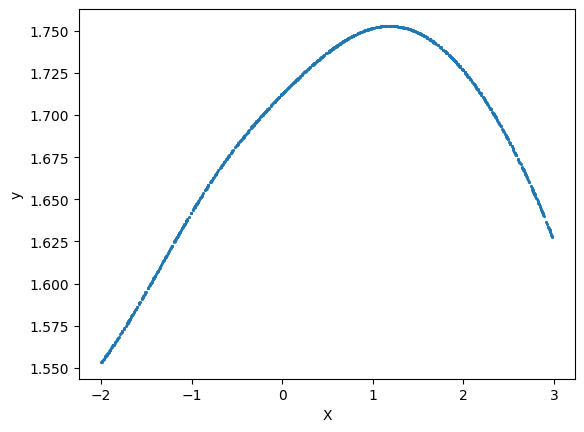

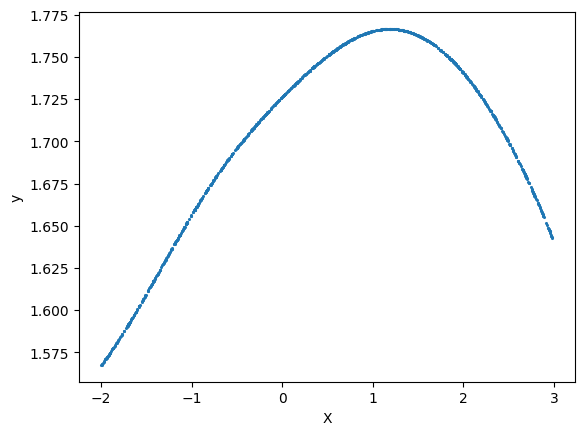

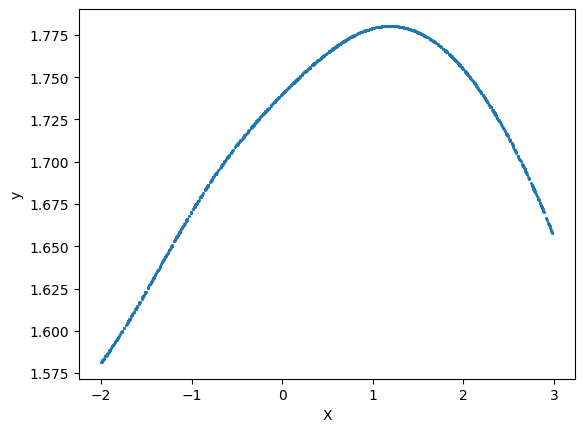

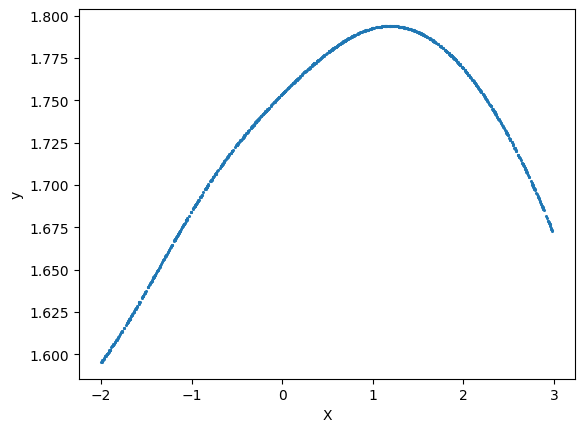

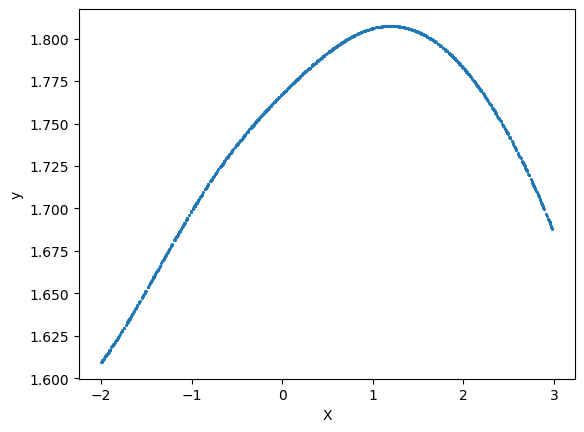

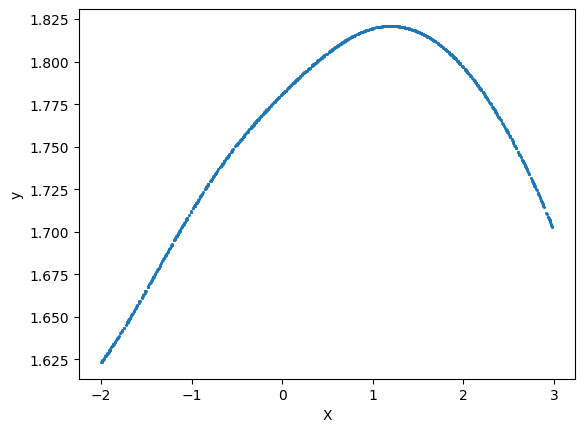

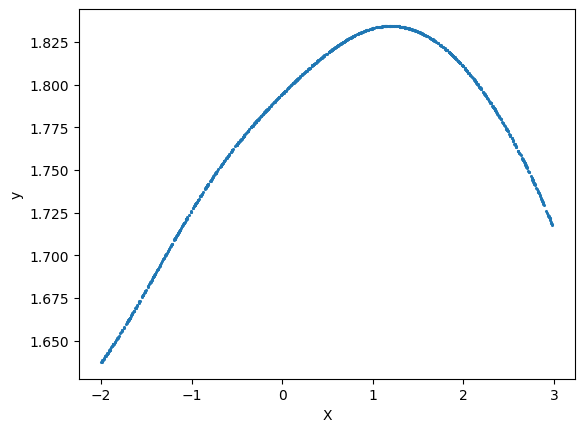

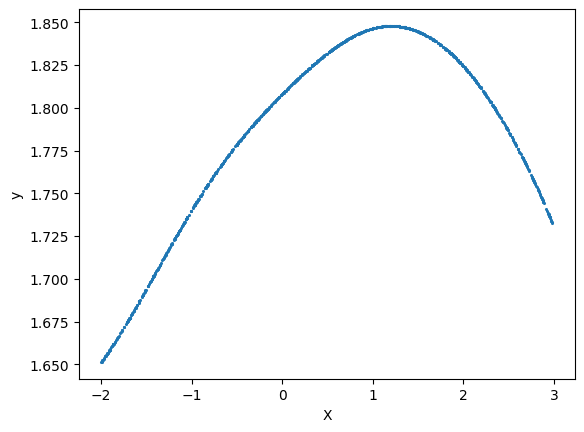

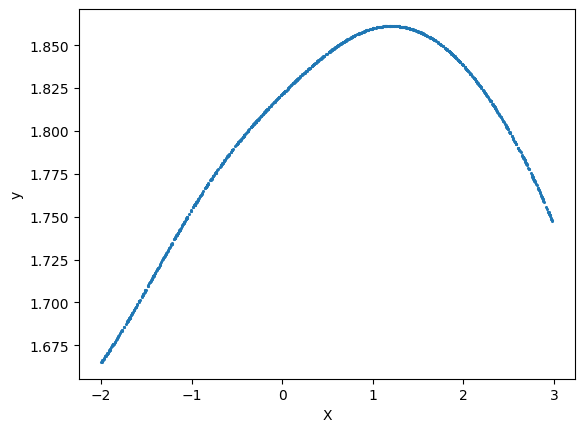

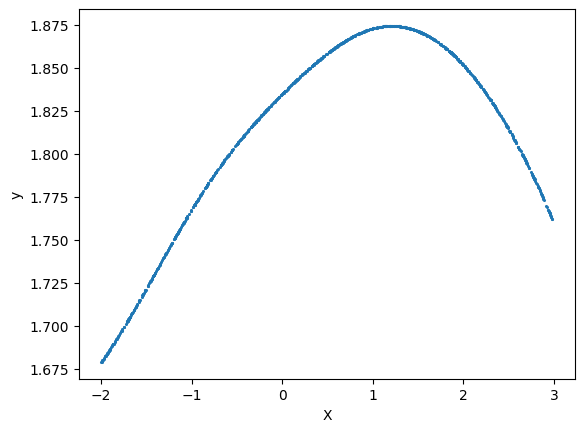

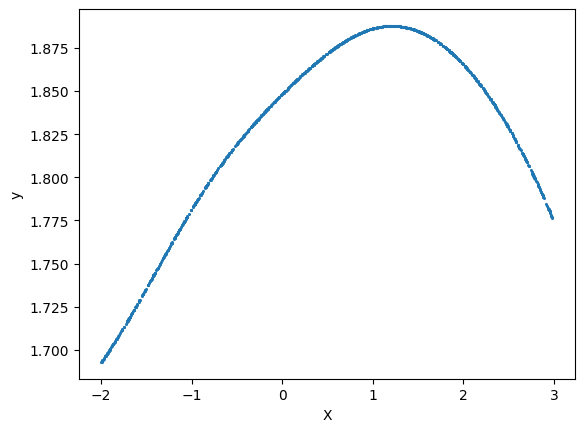

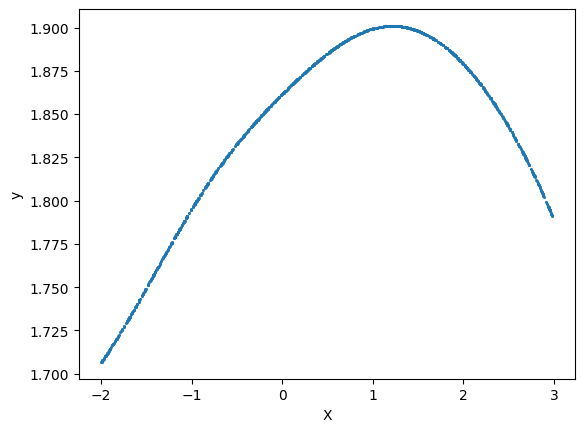

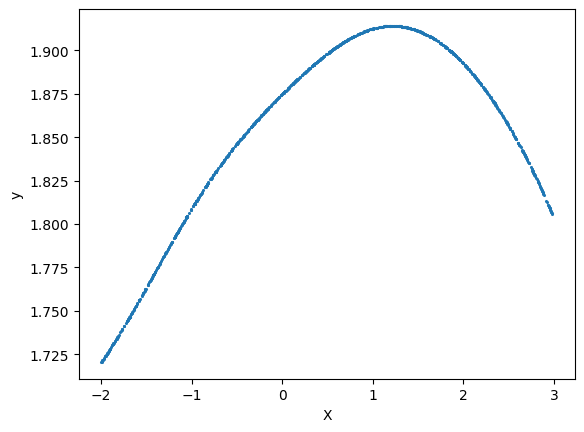

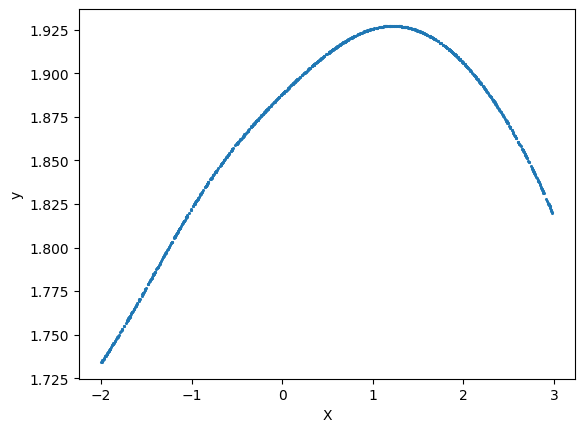

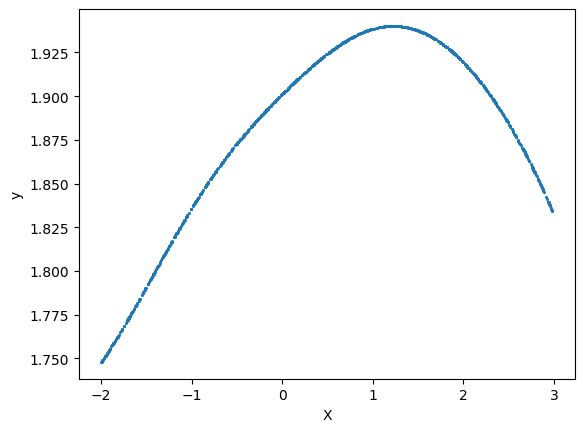

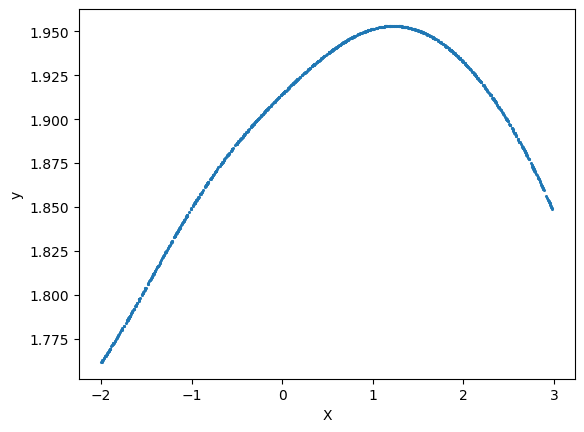

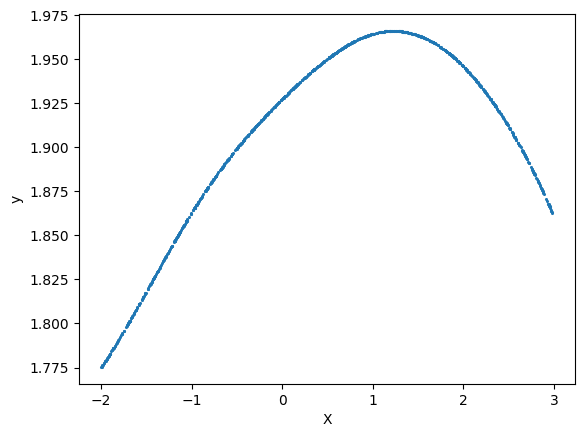

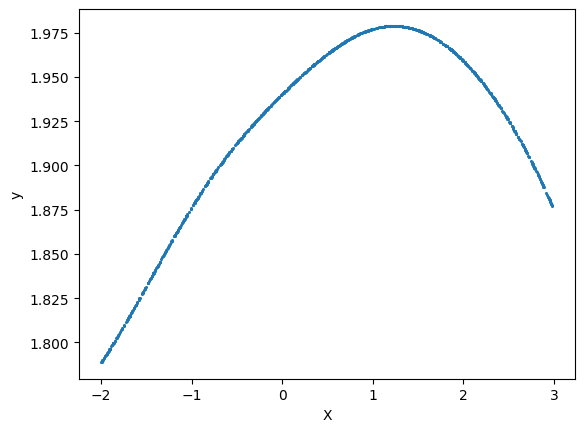

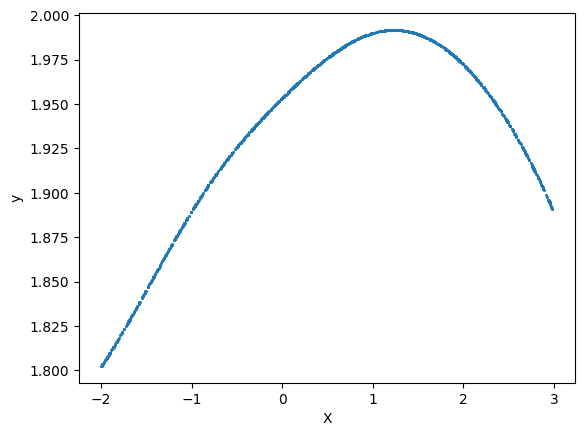

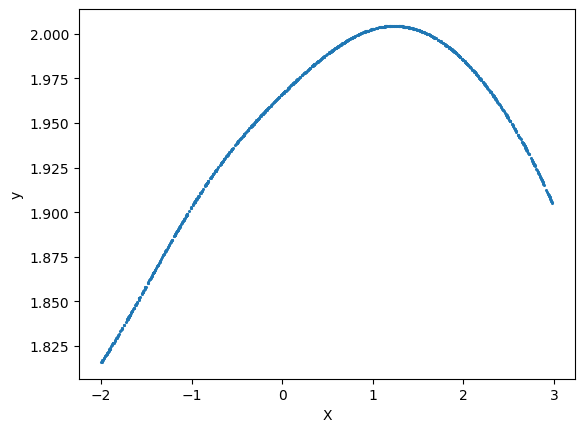

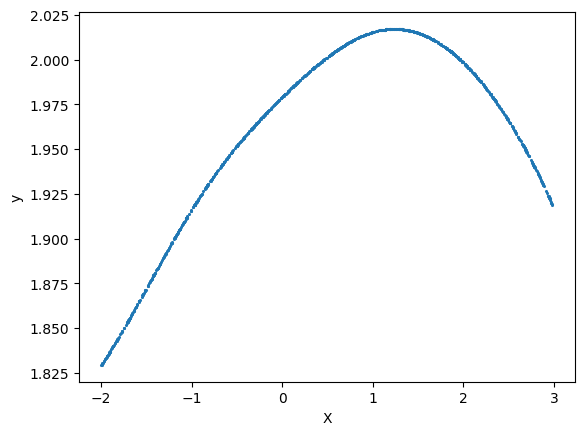

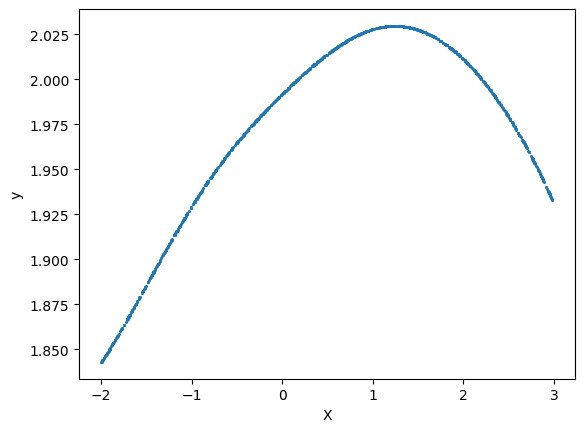

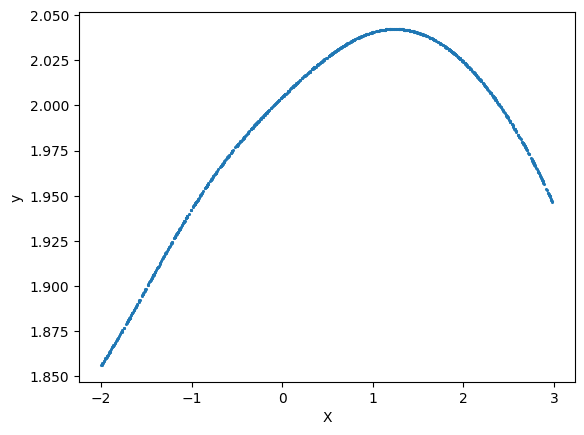

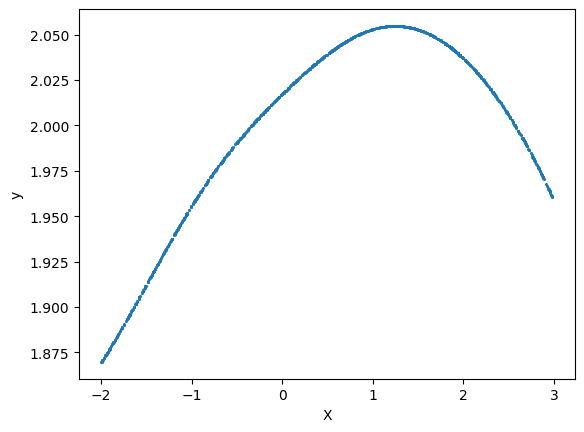

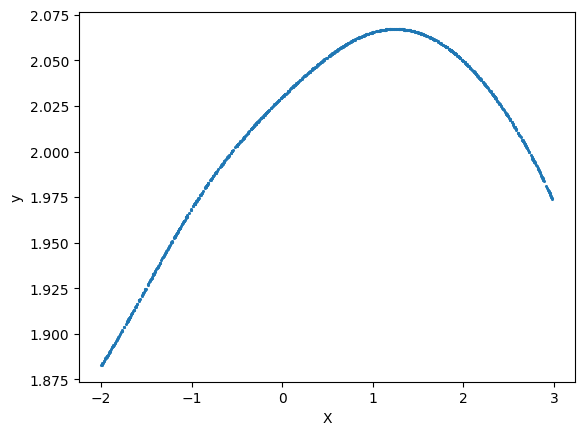

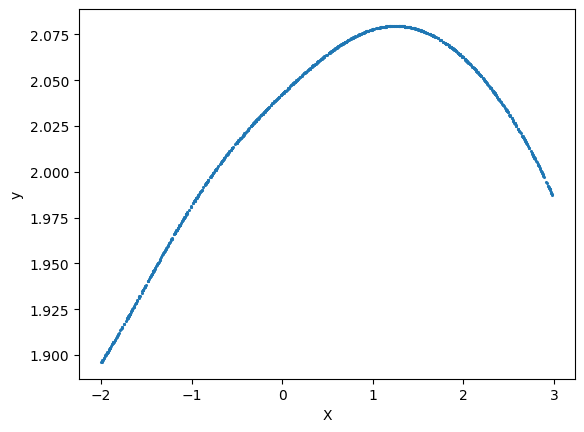

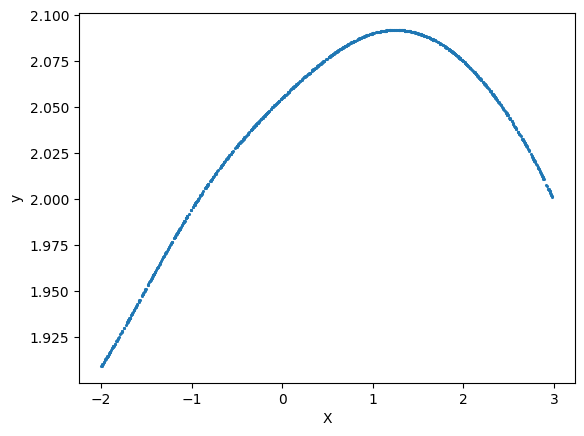

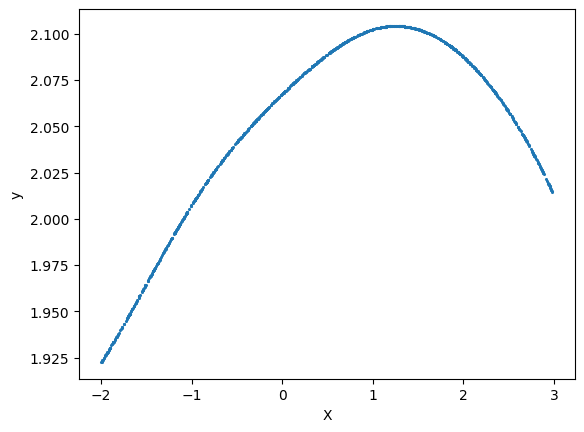

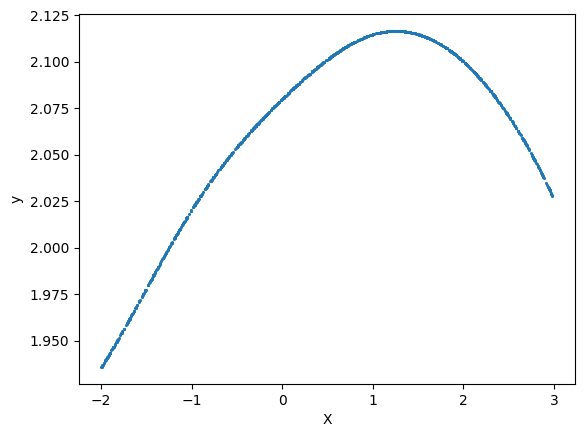

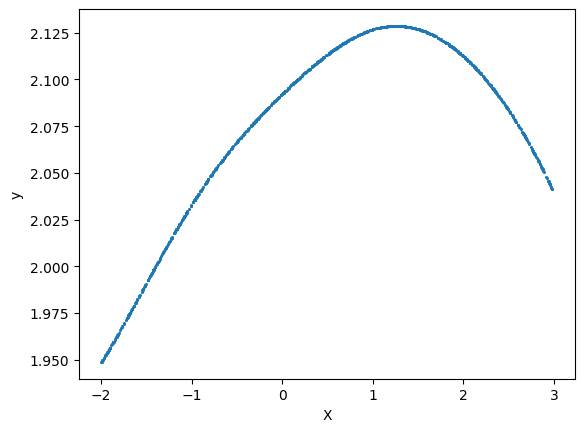

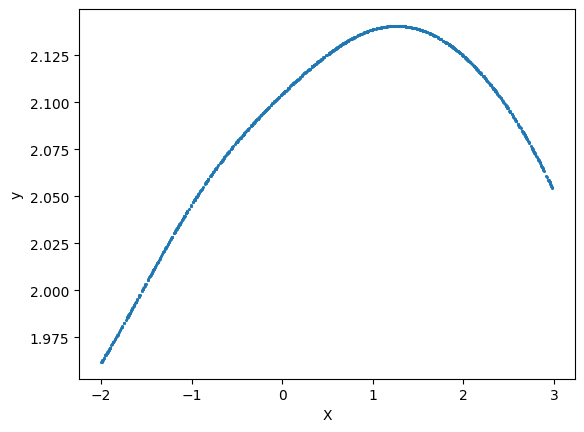

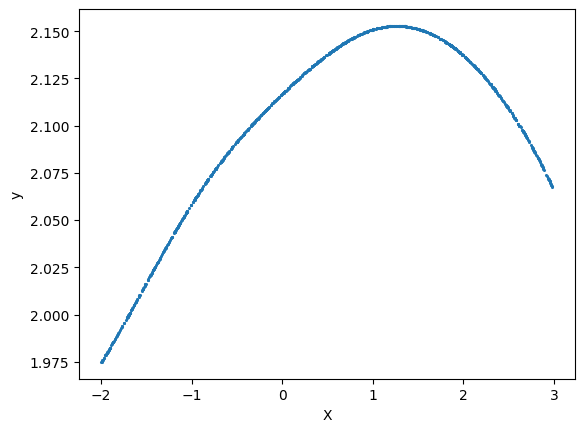

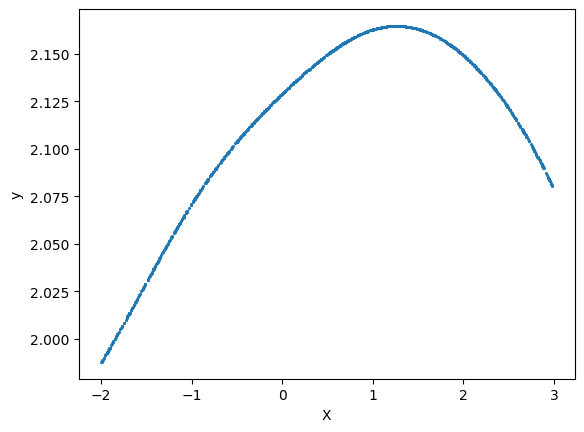

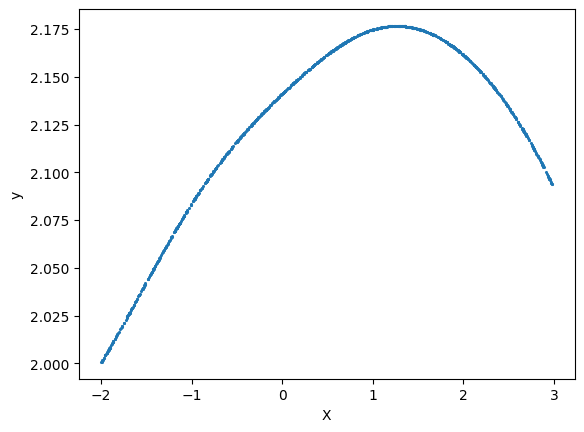

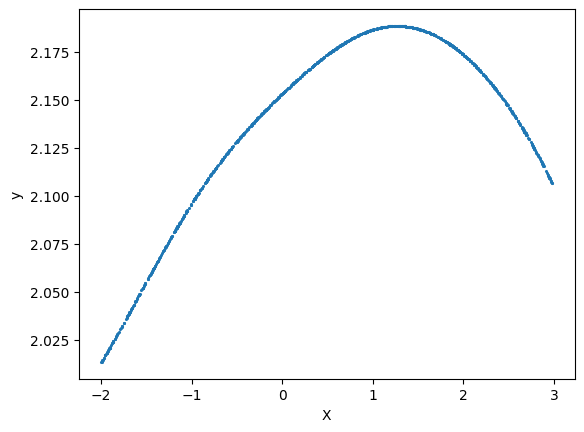

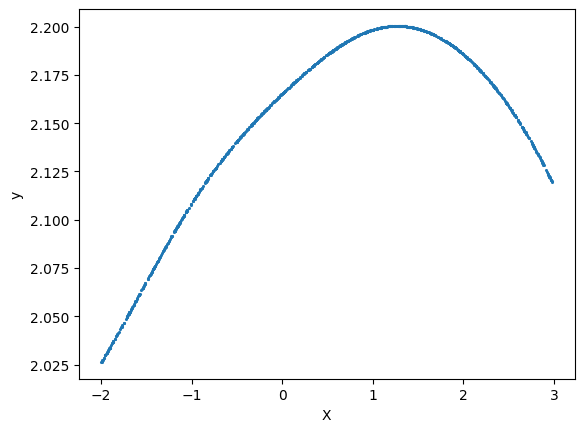

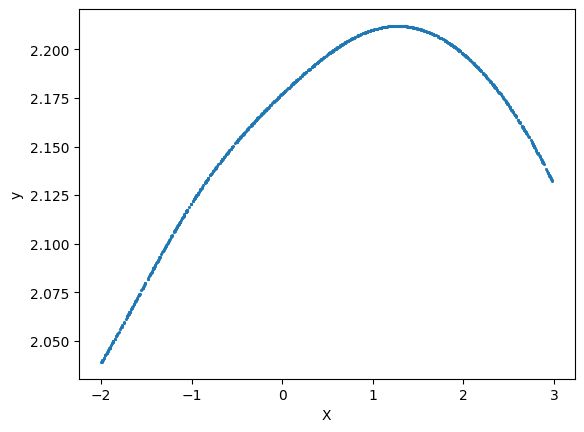

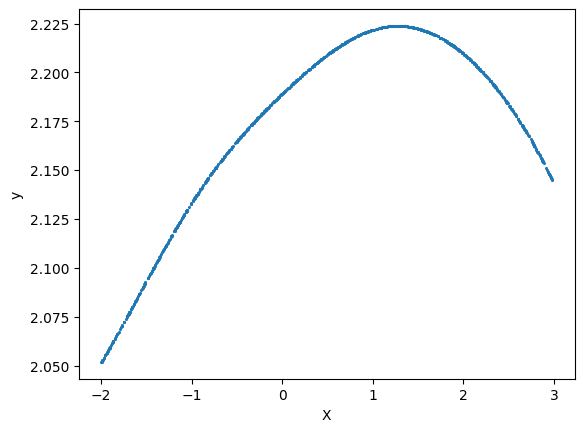

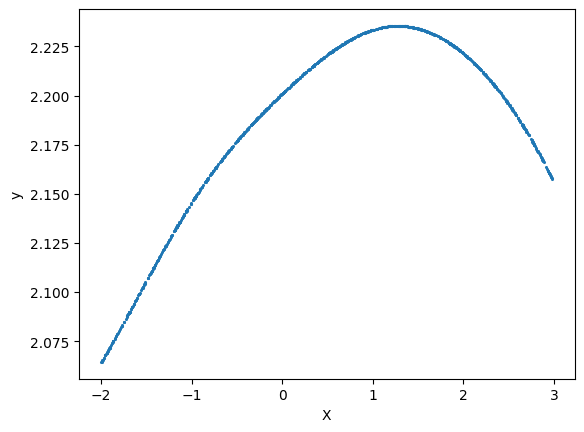

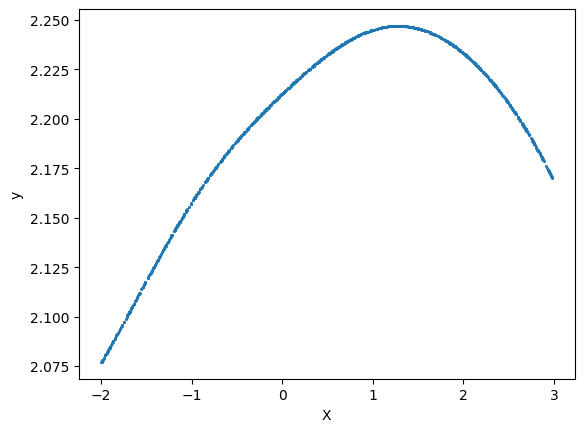

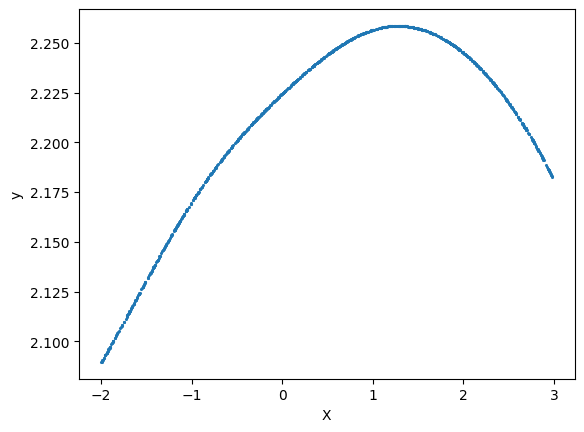

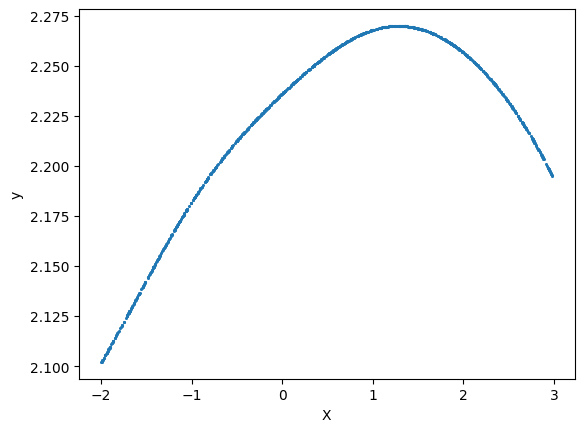

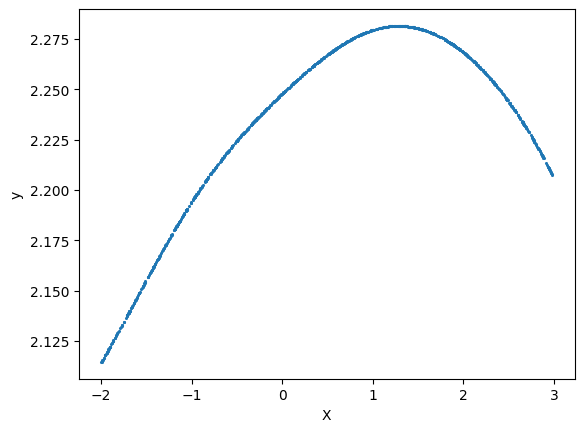

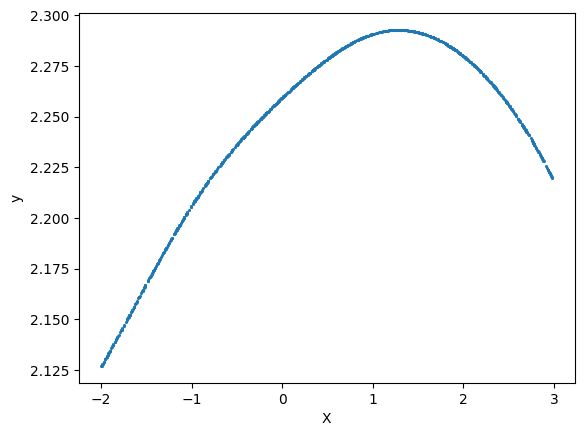

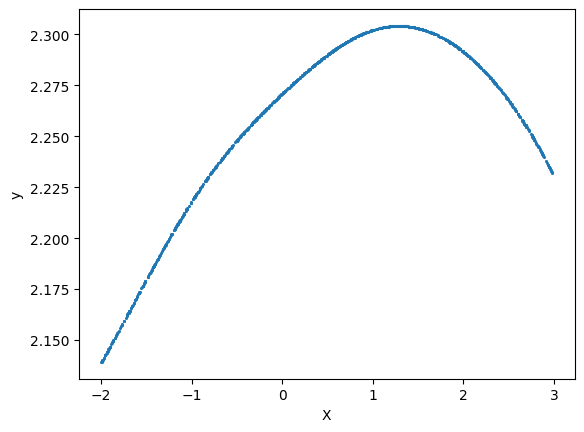

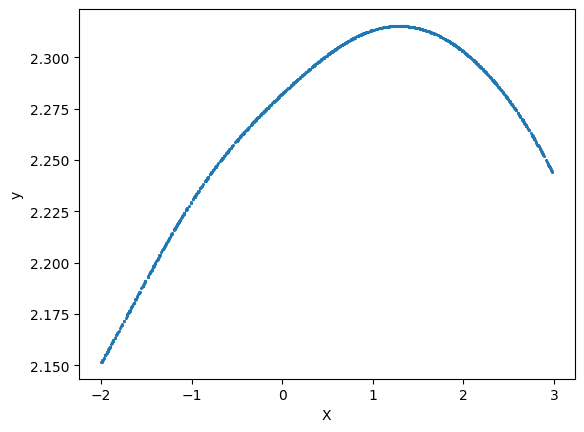

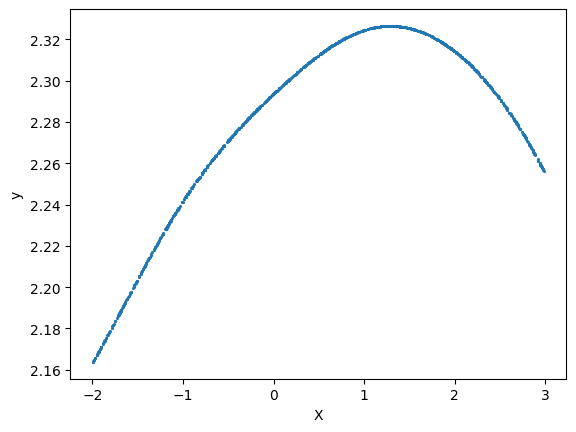

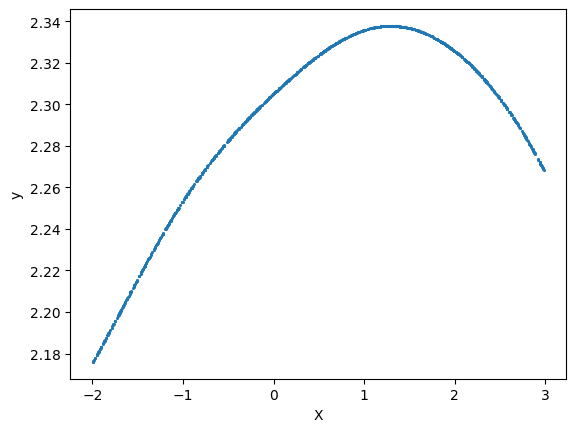

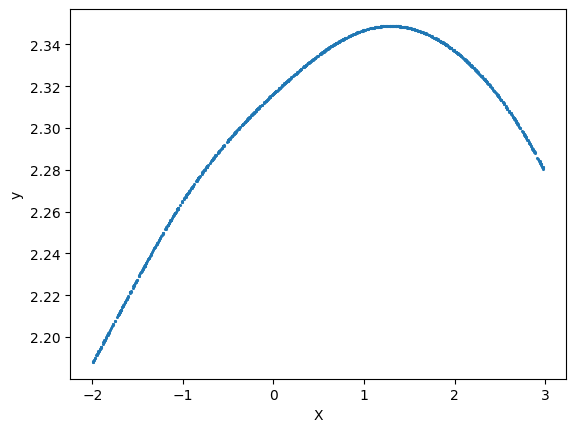

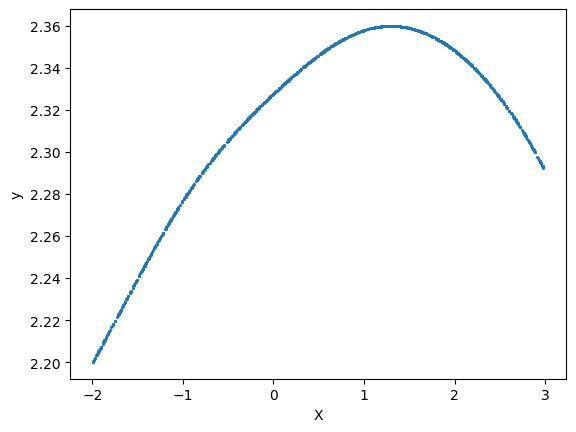

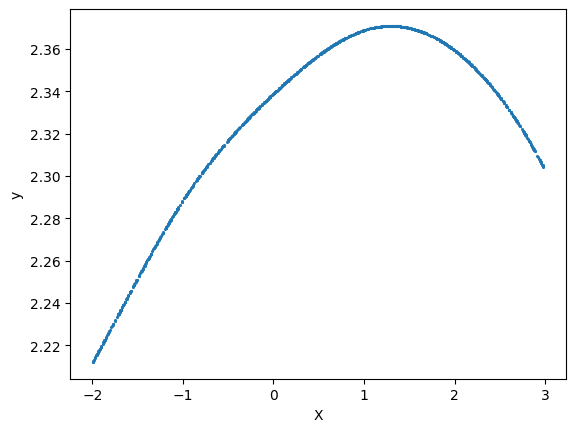

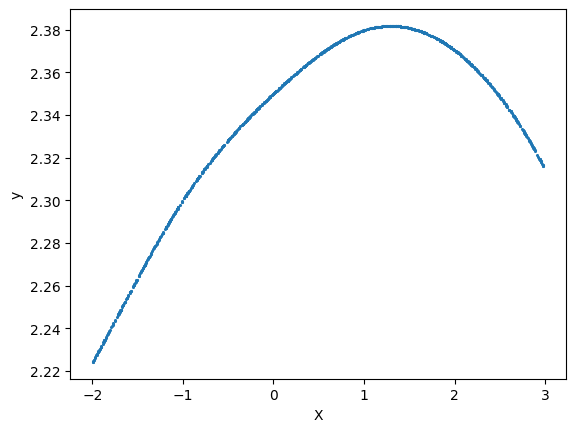

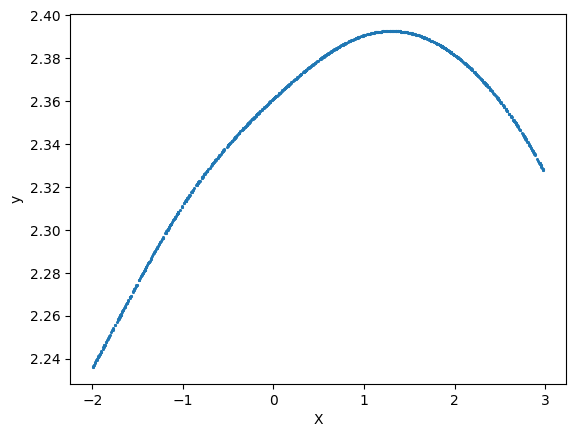

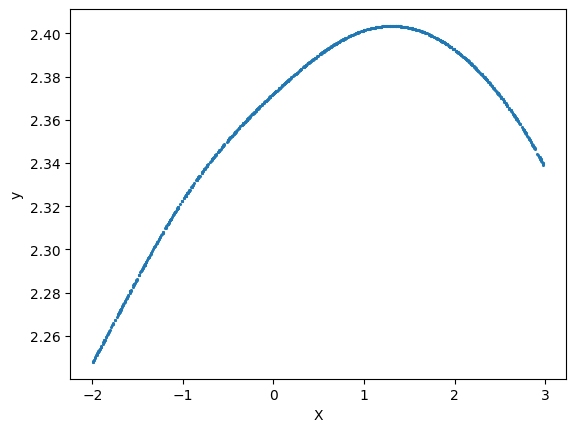

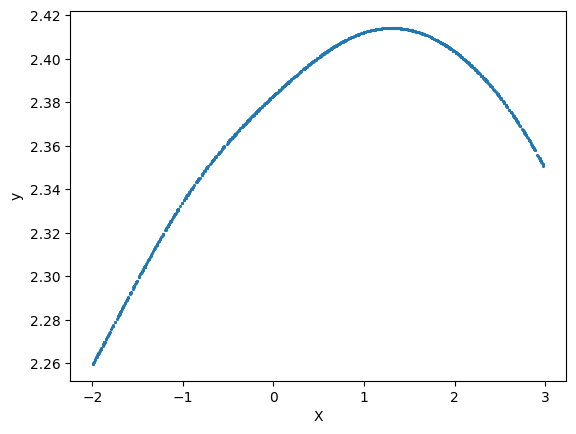

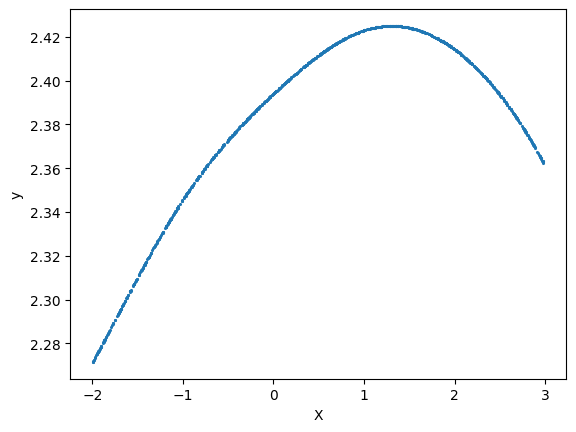

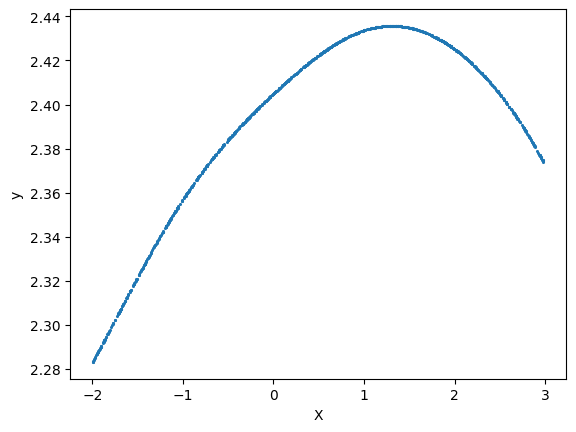

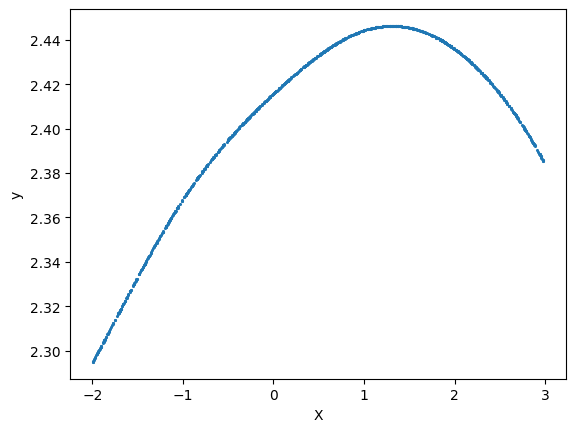

In [13]:
for t in range(200):
    print(f"Epoch: {t+1}\n------------------")
    train_loop(dataset,Parabola_model,loss,opt,1000)
    with torch.no_grad():
        y = pd.DataFrame(Parabola_model(X_tensor),columns=['y'])
    # print(type(y))
        df = pd.concat([X,y],axis=1)
        df.plot(kind='scatter',x='X',y='y',s = 1.5)
        plt.savefig('C:/Projects/AI-learning/Py-torch proto/training.jpg')

In [16]:
with torch.no_grad():
    x = torch.tensor([2.2])
    y = Parabola_model(x)
    print(type(y))

<class 'torch.Tensor'>
